*Current Code comments out all batches that do not have equivalent JBS survey data, these users' burnout cannot be predicted without labels*

In [1]:
from datetime import date
from datetime import datetime
import datetime
import json
import os
import pandas as pd
import re
import glob
import numpy as np
from scipy.stats import *
from statistics import *
import openpyxl
import dateutil
import math
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from statsmodels.stats.multitest import multipletests

**Functions from Github (HREntropy, Step Entropy)**

In [2]:
# Copied over from AMED_shift_worker github
def sampen(L, m, r):
    N = len(L)
    B = 0.0
    A = 0.0

    # Split time series and save all templates of length m
    xmi = np.array([L[i : i + m] for i in range(N - m)])
    xmj = np.array([L[i : i + m] for i in range(N - m + 1)])

    # Save all matches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])

    # Similar for computing A
    m += 1
    xm = np.array([L[i : i + m] for i in range(N - m + 1)])

    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])

    # Return SampEn
    return -np.log(A / B)

In [3]:
# Copied over from AMED_shift_worker github
def cal_entropy(labels, base=None):
    value, count = np.unique(labels, return_counts = True)
    return entropy(count, base=base)
def count_continuous_0period(array):
    res = []
    count = 1
    for i in range(1, len(array)):
        if (array[i] == 0 and array[i-1] == 0):
            count += 1
        elif (array[i] != 0 and array[i-1] == 0):
            res.append(count)
            count = 1
    return res
def count_continuous_1period(array):
    res = []
    count = 1
    for i in range(1, len(array)):
        if (array[i] != 0 and array[i-1] != 0):
            count += 1
        elif (array[i] == 0 and array[i-1] != 0):
            res.append(count)
            count = 1
    return res

# Feature extraction of sleep, heart rate, step data for AMED data set.
**Uncommented code only extracts batch 3,4, and 5**

## Fitbit features batch 3 and 4

In [4]:
# Fitbit features from Batch 3/4

participants = ['1102','1114','1103','1105','1153','1157', '1156','1115','1154','1150','1108','1158', '1155','1151', '1159']

# Initialize subset feature tables
heart_fit = pd.DataFrame([[0,0,0,0,0]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
step_fit = pd.DataFrame([[0,0,0,0,0]], columns = ['User','Date','Steps', 'ActiveEntropy', 'NonActiveEntropy'])
sleep_fit = pd.DataFrame([[0,0,0,0,0,0,0]], columns = ['User','Date','StartSleep', 'EndSleep', 'SleepEfficiency', 'SleepDuration', 'SleepRestlessness'])

# Iterate through participants
for p in participants:
    
    # Some data in data_20210311, some in WellbeingData folder (different batches)
    if p in ['1159', '1158', '1105', '1151', '1114', '1150', '1157', '1156', '1108']:
        heart_files = glob.glob('/Users/giabraddock/compwell/data_20210311/* fitbit/{}_heart_[2020-2021]*.json'.format(p))
        step_files = glob.glob('/Users/giabraddock/compwell/data_20210311/* fitbit/{}_steps_[2020-2021]*.json'.format(p))
        sleep_files = glob.glob('/Users/giabraddock/compwell/data_20210311/* fitbit/{}_sleep_[2020-2021]*.json'.format(p))
    else:
        heart_files = glob.glob('/Users/giabraddock/compwell/WellbeingData_20210214/fitbit_data_20210214/{}/*/{}_heart_[2020-2021]*.json'.format(p,p))
        step_files = glob.glob('/Users/giabraddock/compwell/WellbeingData_20210214/fitbit_data_20210214/{}/*/{}_steps_*.json'.format(p,p))
        sleep_files = glob.glob('/Users/giabraddock/compwell/WellbeingData_20210214/fitbit_data_20210214/{}/*/{}_sleep_*.json'.format(p,p))

    # Extraction for heart features 
    for h in heart_files:
        hfile = open(h)
        data = json.load(hfile)
        time_val_list = data['activities-heart-intraday']['dataset']
        date = data["activities-heart"][0]['dateTime']
        # list of heart rate by minute
        heart_stats = []
        for item in time_val_list:
            heart_stats.append(item['value'])
        if len(heart_stats) > 0:
            hs = pd.DataFrame([[p,date,mean(heart_stats), np.std(heart_stats), sampen(heart_stats, 2, 0.2*np.std(heart_stats))]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
            heart_fit = pd.concat([heart_fit, hs], ignore_index=True)
        else:
            hs = pd.DataFrame([[p,date,None, None, None]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
            heart_fit = pd.concat([heart_fit, hs], ignore_index=True)

    # Extraction for step features
    for st in step_files:
        stfile = open(st)
        datast = json.load(stfile)
        time_val_list = datast['activities-steps-intraday']['dataset']
        date = datast["activities-steps"][0]['dateTime']
        # List of steps by minute
        step_stats = []
        for item in time_val_list:
            step_stats.append(item['value'])
        # Steps in the day
        total_step = int(datast["activities-steps"][0]['value'])
        # Calculate nonactive and active entropy
        if len(step_stats) > 0:
            time_not_active = count_continuous_0period(step_stats)
            time_active = count_continuous_1period(step_stats)
            inactive_entropy = cal_entropy(time_not_active)
            active_entropy = cal_entropy(time_active)
        else:
            inactive_entropy = None
            active_entropy = None
        sts = pd.DataFrame([[p,date,total_step, active_entropy, inactive_entropy]], columns = ['User','Date','Steps', 'ActiveEntropy', 'NonActiveEntropy'])
        step_fit = pd.concat([step_fit, sts], ignore_index=True)

    # Extraction for sleep features
    for sl in set(sleep_files):
        slfile = open(sl)
        datasl = json.load(slfile)
        if len(datasl['sleep']) > 0:
            # Get sleep info 
            date = datasl["sleep"][0]['dateOfSleep']
            duration = datasl["sleep"][0]['minutesAsleep']
            efficiency = datasl["sleep"][0]['efficiency']
            start = datasl["sleep"][0]['startTime']
            end = datasl["sleep"][0]['endTime']
            # Less than 85% efficiency signifies restless sleep
            restlessness = 1 if efficiency < 85 else 0
            sls = pd.DataFrame([[p,date,start, end, efficiency, duration, restlessness]], columns = ['User','Date','StartSleep', 'EndSleep', 'SleepEfficiency', 'SleepDuration', 'SleepRestlessness']) 
            sleep_fit = pd.concat([sleep_fit, sls], ignore_index=True)   


# Get rid of row of zeroes made when initializing
heart_fitbit = heart_fit.drop(labels=[0], axis = 0)
step_fitbit = step_fit.drop(labels=[0], axis=0)
sleep_fitbit = sleep_fit.drop(labels=[0], axis=0)

In [6]:
# Combine heart, sleep, step feature for batch 3/4
fit = heart_fitbit.merge(step_fitbit, how='outer',on=['User', 'Date'])
fitbit_feat1 = fit.merge(sleep_fitbit, how='outer',on=['User', 'Date'])
# Incase of repeated files
fitbit_feat1.drop_duplicates(inplace=True)
fitbit_feat1.head(5)

,User,Date,HRMean,HRSTD,HREntropy,Steps,ActiveEntropy,NonActiveEntropy,StartSleep,EndSleep,SleepEfficiency,SleepDuration,SleepRestlessness
0,1102,2020-12-18,76.547692,17.412463,0.454588,10523,1.605808,2.709059,2020-12-17T23:49:30.000,2020-12-18T07:09:30.000,97.0,386.0,0.0
1,1102,2020-12-02,69.961712,13.361037,0.566377,7000,1.751306,2.794203,2020-12-02T00:12:30.000,2020-12-02T06:33:00.000,98.0,330.0,0.0
2,1102,2020-12-14,69.751067,9.379879,0.878989,5093,1.505187,2.712200,2020-12-13T23:34:30.000,2020-12-14T07:10:00.000,95.0,388.0,0.0
3,1102,2020-12-03,60.273756,8.134319,0.562999,2912,1.585771,1.839297,2020-12-03T01:25:00.000,2020-12-03T06:34:30.000,97.0,266.0,0.0
4,1102,2020-12-19,71.134697,10.662805,0.520826,8099,1.644492,2.880134,2020-12-19T13:58:30.000,2020-12-19T15:14:30.000,91.0,69.0,0.0


## Fitbit features batch 1 (commented out due to lack of JBS data)

In [5]:
# # Batch 1 participants have a different ID and fitbit format 

# # Initialize subset feature tables
# heart_fit = pd.DataFrame([[0,0,0,0,0]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
# step_fit = pd.DataFrame([[0,0,0,0,0]], columns = ['User','Date','Steps', 'ActiveEntropy', 'NonActiveEntropy'])
# sleep_fit = pd.DataFrame([[0,0,0,0,0,0,0]], columns = ['User','Date','StartSleep', 'EndSleep', 'SleepEfficiency', 'SleepDuration', 'SleepRestlessness'])

# # Iterate through participants 
# for p in ['fitbit001', 'fitbit002', 'fitbit003', 'fitbit004', 'fitbit005', 'fitbit006', 'fitbit009', 'fitbit010', 'fitbit011', 'fitbit014']:
#     heart_files = glob.glob('/Users/giabraddock/batch1/{}/heart/*.json'.format(p))
#     step_files = glob.glob('/Users/giabraddock/batch1/{}/steps/*.json'.format(p))
#     sleep_files = glob.glob('/Users/giabraddock/batch1/{}/sleep/*.json'.format(p))

#     # Extraction for heart features 
#     for h in heart_files:
#         hfile = open(h)
#         datah = json.load(hfile)
#         # list of heart rate by minute
#         date = datah['activities-heart'][0]['dateTime']
#         # Some files are empty dictionaries or only contain resting heart rate for the day
#         if 'activities-heart-intraday' not in datah.keys() or len(datah['activities-heart-intraday']['dataset']) == 0:
#             hs = pd.DataFrame([[p,date,None, None, None]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
#         else:
#             values = [x['value'] for x in datah['activities-heart-intraday']['dataset']]
#             hs = pd.DataFrame([[p,date,mean(values),np.std(values), sampen(values, 2, 0.2*np.std(values))]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
#         heart_fit = pd.concat([heart_fit, hs], ignore_index=True)
        
#     # Extraction for step features
#     for st in step_files:
#         stfile = open(st)
#         datast = json.load(stfile)
#         date = datast['activities-steps'][0]['dateTime']
#         # Steps in the day
#         total_steps = datast['activities-steps'][0]['value']
#         # Some files are empty dictionaries
#         if 'activities-steps-intraday' not in datast.keys():
#             sts = pd.DataFrame([[p,date,total_steps, None, None]], columns = ['User','Date','Steps', 'ActiveEntropy', 'NonActiveEntropy'])
#         else:
#             # List of steps by minute
#             values = [x['value'] for x in datast['activities-steps-intraday']['dataset']]
#             # Calculate nonactive and active entropy
#             time_not_active = count_continuous_0period(values)
#             time_active = count_continuous_1period(values)
#             inactive_entropy = cal_entropy(time_not_active)
#             active_entropy = cal_entropy(time_active)
#             sts = pd.DataFrame([[p,date,total_steps, active_entropy, inactive_entropy]], columns = ['User','Date','Steps', 'ActiveEntropy', 'NonActiveEntropy'])
#         step_fit = pd.concat([step_fit, sts], ignore_index=True)

#     # Extraction for sleep features
#     for sl in sleep_files:
#         slfile = open(sl)
#         datasl = json.load(slfile)
#         # If empty dictionary, need to manually calculate date
#         if len(datasl['sleep']) == 0:
#             date = sl.split('/')[-1].split('.')[0]
#             sls = pd.DataFrame([[p,date,None, None, None, None, None, None, None]], columns = ['User','Date','StartSleep', 'EndSleep', 'SleepEfficiency', 'SleepDuration', 'SleepRestlessness', 'NumberofNaps','NapDuration']) 
#         else:
#             date = datasl['sleep'][0]['dateOfSleep']
#             # If no naps, only need to iterate once through the dictionary
#             if len(datasl['sleep']) == 1:
#                 duration = datasl['sleep'][0]['minutesAsleep']
#                 efficiency = datasl['sleep'][0]['efficiency']
#                 start = datasl["sleep"][0]['startTime']
#                 end = datasl["sleep"][0]['endTime']
#                 restlessness = 1 if efficiency < 85 else 0
#                 sls = pd.DataFrame([[p,date,start, end, efficiency, duration, restlessness, 0, 0]], columns = ['User','Date','StartSleep', 'EndSleep', 'SleepEfficiency', 'SleepDuration', 'SleepRestlessness', 'NumberofNaps','NapDuration']) 
#             # If the participant napped, the initial dictionary key will have multiple items in the value list
#             elif len(datasl['sleep']) > 1:
#                 naps = 0
#                 napduration = 0
#                 for i in range(len(datasl['sleep'])):
#                     if datasl['sleep'][i]['isMainSleep'] == True:
#                         duration = datasl['sleep'][i]['minutesAsleep']
#                         efficiency = datasl['sleep'][i]['efficiency']
#                         start = datasl["sleep"][i]['startTime']
#                         end = datasl["sleep"][i]['endTime']
#                         restlessness = 1 if efficiency < 85 else 0
#                     # Naps marked by 'isMainSleep' key
#                     elif datasl['sleep'][i]['isMainSleep'] == False:
#                         naps += 1
#                         napduration += datasl['sleep'][i]['minutesAsleep']
#                 sls = pd.DataFrame([[p,date,start, end, efficiency, duration, restlessness, naps, napduration]], columns = ['User','Date','StartSleep', 'EndSleep', 'SleepEfficiency', 'SleepDuration', 'SleepRestlessness', 'NumberofNaps','NapDuration']) 
#         sleep_fit = pd.concat([sleep_fit, sls], ignore_index=True)   

# # Drop row of zeroes added during initialization 
# heart_fitbit2 = heart_fit.drop(labels=[0], axis = 0)
# step_fitbit2 = step_fit.drop(labels=[0], axis=0)
# sleep_fitbit2 = sleep_fit.drop(labels=[0], axis=0)

In [9]:
# # Combine heart, sleep, step features for batch1
# fit2 = heart_fitbit2.merge(step_fitbit2, how='outer',on=['User', 'Date'])
# fitbit_feat2 = fit2.merge(sleep_fitbit2, how='outer',on=['User', 'Date'])
# fitbit_feat2.head(5)

## Fitbit features batch 5

In [10]:
participants = ['1160', '1161', '1164', '1165', '1167', '1168', '1171', '1173']

# Initialize subset feature tables
heart_fit = pd.DataFrame([[0,0,0,0,0]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
step_fit = pd.DataFrame([[0,0,0,0,0]], columns = ['User','Date','Steps', 'ActiveEntropy', 'NonActiveEntropy'])
sleep_fit = pd.DataFrame([[0,0,0,0,0,0,0]], columns = ['User','Date','StartSleep', 'EndSleep', 'SleepEfficiency', 'SleepDuration', 'SleepRestlessness'])

# Iterate through participants
for p in participants:
    heart_files = glob.glob('/Users/giabraddock/compwell/batch5/Fitbit/fitbits_{}/fitbit_heartrate*.json'.format(p))
    sleep_files = glob.glob('/Users/giabraddock/compwell/batch5/Fitbit/fitbits_{}/fitbit_sleep*.json'.format(p))
    step_files = glob.glob('/Users/giabraddock/compwell/batch5/Fitbit/fitbits_{}/fitbit_step*.json'.format(p))
    
        # Extraction for heart features 
    for h in heart_files:
        hfile = open(h)
        data = json.load(hfile)
        time_val_list = data['activities-heart-intraday']['dataset']
        date = data["activities-heart"][0]['dateTime']
        # list of heart rate by minute
        heart_stats = []
        for item in time_val_list:
            heart_stats.append(item['value'])
        if len(heart_stats) > 0:
            hs = pd.DataFrame([[p,date,mean(heart_stats), np.std(heart_stats), sampen(heart_stats, 2, 0.2*np.std(heart_stats))]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
            heart_fit = pd.concat([heart_fit, hs], ignore_index=True)
        else:
            hs = pd.DataFrame([[p,date,None, None, None]], columns = ['User','Date','HRMean', 'HRSTD', 'HREntropy'])
            heart_fit = pd.concat([heart_fit, hs], ignore_index=True)

    # Extraction for step features
    for st in step_files:
        stfile = open(st)
        datast = json.load(stfile)
        time_val_list = datast['activities-steps-intraday']['dataset']
        date = datast["activities-steps"][0]['dateTime']
        # List of steps by minute
        step_stats = []
        for item in time_val_list:
            step_stats.append(item['value'])
        # Steps in the day
        total_step = int(datast["activities-steps"][0]['value'])
        # Calculate nonactive and active entropy
        if len(step_stats) > 0:
            time_not_active = count_continuous_0period(step_stats)
            time_active = count_continuous_1period(step_stats)
            inactive_entropy = cal_entropy(time_not_active)
            active_entropy = cal_entropy(time_active)
        else:
            inactive_entropy = None
            active_entropy = None
        sts = pd.DataFrame([[p,date,total_step, active_entropy, inactive_entropy]], columns = ['User','Date','Steps', 'ActiveEntropy', 'NonActiveEntropy'])
        step_fit = pd.concat([step_fit, sts], ignore_index=True)

    # Extraction for sleep features
    for sl in set(sleep_files):
        slfile = open(sl)
        datasl = json.load(slfile)
        if len(datasl['sleep']) > 0:
            # Get sleep info 
            date = datasl["sleep"][0]['dateOfSleep']
            duration = datasl["sleep"][0]['minutesAsleep']
            efficiency = datasl["sleep"][0]['efficiency']
            start = datasl["sleep"][0]['startTime']
            end = datasl["sleep"][0]['endTime']
            # Less than 85% efficiency signifies restless sleep
            restlessness = 1 if efficiency < 85 else 0
            sls = pd.DataFrame([[p,date,start, end, efficiency, duration, restlessness]], columns = ['User','Date','StartSleep', 'EndSleep', 'SleepEfficiency', 'SleepDuration', 'SleepRestlessness']) 
            sleep_fit = pd.concat([sleep_fit, sls], ignore_index=True)   


# Get rid of row of zeroes made when initializing
heart_fitbit = heart_fit.drop(labels=[0], axis = 0)
step_fitbit = step_fit.drop(labels=[0], axis=0)
sleep_fitbit = sleep_fit.drop(labels=[0], axis=0)

<ipython-input-2-8fa2c8aa67b4>:21: RuntimeWarning: invalid value encountered in long_scalars
  return -np.log(A / B)


In [11]:
# Combine heart, sleep, step features for batch5
fit2 = heart_fitbit.merge(step_fitbit, how='outer',on=['User', 'Date'])
fitbit_feat2 = fit2.merge(sleep_fitbit, how='outer',on=['User', 'Date'])
fitbit_feat2.head(5)

,User,Date,HRMean,HRSTD,HREntropy,Steps,ActiveEntropy,NonActiveEntropy,StartSleep,EndSleep,SleepEfficiency,SleepDuration,SleepRestlessness
0,1160,2021-03-19,74.888773,19.408967,0.240277,5444,2.054696,2.195664,2021-03-19T12:48:00.000,2021-03-19T14:43:30.000,96.0,110.0,0.0
1,1160,2021-03-23,80.836113,16.056530,0.320313,10128,1.897523,2.109084,2021-03-22T21:23:00.000,2021-03-23T06:44:30.000,94.0,490.0,0.0
2,1160,2021-03-15,85.471886,18.805544,0.405262,9981,1.994587,2.276043,2021-03-14T21:21:00.000,2021-03-15T06:04:00.000,94.0,450.0,0.0
3,1160,2021-03-03,79.802158,18.440193,0.362957,12813,2.098400,1.946124,2021-03-02T21:31:00.000,2021-03-03T06:06:30.000,96.0,454.0,0.0
4,1160,2021-03-02,81.796137,17.268330,0.404227,13270,2.063462,1.812986,2021-03-02T04:18:00.000,2021-03-02T06:41:00.000,95.0,136.0,0.0


In [12]:
# Combine all batches into one table
fitbit_feat = pd.concat([fitbit_feat2, fitbit_feat1], axis=0, ignore_index=True)
fitbit_feat.tail()

,User,Date,HRMean,HRSTD,HREntropy,Steps,ActiveEntropy,NonActiveEntropy,StartSleep,EndSleep,SleepEfficiency,SleepDuration,SleepRestlessness
774,1159,2021-03-03,69.476710,14.763856,0.365377,12370,2.149539,1.983458,2021-03-02T22:18:00.000,2021-03-03T06:26:00.000,93.0,436.0,0.0
775,1159,2021-03-02,69.515625,12.928652,0.443915,12232,2.067978,2.112574,2021-03-01T23:13:30.000,2021-03-02T06:48:30.000,93.0,401.0,0.0
776,1159,2021-03-01,67.731935,13.869704,0.435500,9153,1.705027,2.512525,2021-02-28T22:42:30.000,2021-03-01T06:20:30.000,94.0,407.0,0.0
777,1159,2021-03-07,71.708944,15.631559,0.324120,12952,2.093961,1.901412,2021-03-06T22:24:00.000,2021-03-07T07:47:00.000,92.0,493.0,0.0
778,1159,2021-03-06,68.599564,12.154121,0.502965,9040,1.868092,2.248551,2021-03-05T21:58:30.000,2021-03-06T08:01:30.000,97.0,543.0,0.0


In [14]:
fitbit_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779 entries, 0 to 778
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   User               779 non-null    object 
 1   Date               779 non-null    object 
 2   HRMean             762 non-null    float64
 3   HRSTD              762 non-null    float64
 4   HREntropy          761 non-null    float64
 5   Steps              779 non-null    int64  
 6   ActiveEntropy      779 non-null    float64
 7   NonActiveEntropy   779 non-null    float64
 8   StartSleep         689 non-null    object 
 9   EndSleep           689 non-null    object 
 10  SleepEfficiency    689 non-null    float64
 11  SleepDuration      689 non-null    float64
 12  SleepRestlessness  689 non-null    float64
dtypes: float64(8), int64(1), object(4)
memory usage: 79.2+ KB


## Remove data outside of trial period

In [15]:
schedule = pd.read_excel('/Users/giabraddock/Downloads/Schedule.xlsx')
# Loading excel file results in a row of zeros
schedule.drop([0], inplace=True)
# Set column names
schedule.columns = schedule.iloc[0]
schedule.drop([1], inplace=True)
schedule.head(5)

1,Sbj. #,Job,U_ID,Begin,End,Abend,44136,44137,44138,44139,...,44318,44319,44320,44321,44322,44323,44324,44325,44326,44327
2,4,Dr.,1103,2020-11-02 00:00:00,2020-12-06 00:00:00,NaN,NaN,Pre-intervention,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,Ns.,1105,2020-11-02 00:00:00,2020-12-06 00:00:00,NaN,NaN,Pre-intervention,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,Dr.,1102,2020-11-16 00:00:00,2020-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7,Ns.,1150,2020-11-16 00:00:00,2020-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,9,Ns.,1115,2020-11-30 00:00:00,2021-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Need to drop fitbit data that was not generated during the experiment
drop_idx = []
for fitidx, row in fitbit_feat.iterrows():
    # Get user and date for every fitbit observation
    u = row['User']
    date = datetime.datetime.strptime(row['Date'], '%Y-%m-%d')

    # Check if date falls within study period (for batch 5 is not in this schedule table)
    for idx, user in schedule["U_ID"].items():
        if str(user) == u:
            user_idx = idx
            begin = schedule.at[user_idx, 'Begin']
            end = schedule.at[user_idx, 'End']

    if (date < begin) or (date > end):
        drop_idx.append(fitidx)

# Clean frame
fitbit_feat.drop(drop_idx, inplace=True)

fitbit_feat.loc[:, 'User'].value_counts()

1157    35
1156    35
1150    35
1158    35
1108    35
1151    35
1161    35
1103    35
1160    35
1105    35
1155    34
1102    33
1115    32
1154    31
1153    29
1114    28
1164    21
1165     7
1159     7
Name: User, dtype: int64

**Inspect Sleep Restlessness Feature**

In [17]:
fitbit_feat.loc[fitbit_feat['SleepRestlessness'] == 1]

,User,Date,HRMean,HRSTD,HREntropy,Steps,ActiveEntropy,NonActiveEntropy,StartSleep,EndSleep,SleepEfficiency,SleepDuration,SleepRestlessness
59,1161,2021-04-09,76.193694,15.964441,0.656388,16682,1.995800,2.214681,2021-04-09T14:11:30.000,2021-04-09T15:20:30.000,74.0,51.0,1.0
346,1103,2020-11-30,79.667104,13.734968,0.806202,4963,1.582357,2.353832,2020-11-30T15:29:00.000,2020-11-30T17:52:00.000,80.0,114.0,1.0
362,1103,2020-11-10,78.473171,12.334900,0.883256,6261,1.630810,2.417296,2020-11-10T00:18:00.000,2020-11-10T05:24:30.000,84.0,264.0,1.0
365,1103,2020-11-27,73.750576,14.189917,0.669839,4804,1.680443,2.455012,2020-11-27T00:40:00.000,2020-11-27T10:36:30.000,82.0,509.0,1.0
368,1103,2020-11-04,80.433936,13.401815,0.744932,4642,1.541808,2.647359,2020-11-04T00:46:30.000,2020-11-04T11:05:00.000,83.0,505.0,1.0
375,1103,2020-11-29,73.911647,14.411962,0.589222,7541,1.837575,2.374785,2020-11-29T00:36:30.000,2020-11-29T10:59:30.000,84.0,508.0,1.0
381,1103,2020-11-14,94.945853,14.290294,0.937182,4001,1.515498,2.603995,2020-11-14T15:49:00.000,2020-11-14T17:40:30.000,80.0,85.0,1.0
382,1103,2020-11-15,81.420561,16.430608,0.637928,8606,1.587511,2.745528,2020-11-15T20:55:30.000,2020-11-15T22:43:30.000,83.0,85.0,1.0
394,1105,2020-11-21,82.421199,16.676627,0.444543,7794,1.711327,2.575413,2020-11-21T13:04:30.000,2020-11-21T14:34:30.000,81.0,73.0,1.0
463,1157,2021-03-03,67.503948,13.350976,0.658068,12875,2.041938,2.242261,2021-03-03T12:12:00.000,2021-03-03T14:09:30.000,78.0,91.0,1.0


## Remove empty rows

In [18]:
# Incase Users had no fitbit data (heart, sleep, or steps), remove from table
drop = []
for idx, row in fitbit_feat.iterrows():
    if pd.isnull(row['HRMean']) and int(row['Steps']) == 0 and pd.isnull(row['SleepEfficiency']):
        drop.append(idx)
fitbit_feat.drop(drop, inplace=True)

1157    35
1105    35
1156    35
1158    35
1108    35
1161    35
1160    35
1151    34
1155    34
1102    33
1150    33
1115    32
1103    31
1154    31
1153    28
1114    23
1164    21
1165     7
1159     7
Name: User, dtype: int64

In [19]:
fitbit_feat.drop_duplicates(inplace=True)

In [20]:
# Store User and Date info for pairs with full set of fitbit data, will use later to clean feature table
full_fitbit_data = fitbit_feat.loc[:, ['User', 'Date']]

## Sleep Regularity Calculation batch 3, 4, and 5
**This script may only be suitable for some batches due to format of fitbit data**

In [21]:
# Initialize table
sri_table = pd.DataFrame()

# Users to calculate SRI
participants = ['1102','1114','1103', '1105', '1153', '1157', '1156', '1115', '1154', '1150', '1108', '1158', '1155', '1151', '1160', '1161', '1164', '1165', '1167', '1168', '1171', '1173']

for p in participants:
    # batch 3/4
    if p in ['1158', '1105', '1151', '1114', '1150', '1157', '1156', '1108']:
        test_file = glob.glob('/Users/giabraddock/compwell/data_20210311/* fitbit/{}_sleep_*.json'.format(p))
    # batch 5
    elif p in ['1160', '1161', '1164', '1165', '1167', '1168', '1171', '1173']:
        test_file = glob.glob('/Users/giabraddock/compwell/batch5/Fitbit/fitbits_{}/fitbit_sleep*.json'.format(p))
    # batch 3/4
    else:
        test_file = glob.glob('/Users/giabraddock/compwell/WellbeingData_20210214/fitbit_data_20210214/{}/*/{}_sleep_*.json'.format(p,p))

    # Sort chronologically
    pathes = sorted(test_file)
    
    # Get dates for the first and last days of data
    
    # batch 5 names files differently
    if p in ['1160', '1161', '1164', '1165', '1167', '1168', '1171', '1173']:
        # End date
        _, y, m, d = pathes[-1].split('_')[-1].split('.')[0].split('-')
        # Start date
        _, y2,m2,d2 = pathes[0].split('_')[-1].split('.')[0].split('-')
    else:
        # End date
        y, m, d = pathes[-1].split('_')[-1].split('.')[0].split('-')
        # Start date
        y2,m2,d2 = pathes[0].split('_')[-1].split('.')[0].split('-')

    date_end = datetime.date(int(y), int(m), int(d))
    date_start = datetime.date(int(y2),int(m2),int(d2))

    # Total days between first and last day of fitbit data collection
    length = ((date_end - date_start).days + 1)

    # 30 second intervals in the day = 2880
    row_len = 2880
    
    # Stores awake vs. asleep
    res = np.zeros([length+1, row_len])
    exists = [False] * length
    flag_date = [False] * length
    idx2date = [None] * length

    # Iterate through each date in the study period
    for i in range(length):
        delta = datetime.timedelta(days = length - 1 - i)
        date = date_end - delta
        idx2date[i] = date.strftime('%Y-%m-%d')
        year_month = idx2date[i][0:7]
        
        # In case i is out of range of pathes list, manually generate path name
        
        # batch 3/4
        if p in ['1158', '1105', '1151', '1114', '1150', '1157', '1156', '1108']:
            path = pathes[-1][0:54] + '{}_sleep_'.format(p) + idx2date[i] + '.json'
        # batch 5
        elif p in ['1160', '1161', '1164', '1165', '1167', '1168', '1171', '1173']:
            path = '/Users/giabraddock/compwell/batch5/Fitbit/fitbits_{}/fitbit_sleep_{}-'.format(p,p) + idx2date[i] + '.json'
        # batch 3/4
        else:
            path = pathes[-1][0:72] + '{}/'.format(p) + year_month + '/{}_sleep_'.format(p) + idx2date[i] + '.json'
        
        # Skips code if path doesn't exist
        if not os.path.exists(path):
            #print('!')
            continue
        with open(path, 'r') as f:
            sleep = json.load(f)
        # Skips over empty dictionaries
        if (len(sleep['sleep']) == 0):
            continue
        for idx_sleep in range(len(sleep['sleep'])):
            exists[i] = True
            flag_date[i] = True
            type = sleep['sleep'][0]['type']
        # Checks to be sure path is in study range
        if not (0 <= (date_end - date).days < length):
            continue
        for data in sleep['sleep'][0]['levels']['data']:
            time = dateutil.parser.parse(data['dateTime'])
            date = time.date()
            x = length - 1 - (date_end - date).days
            y = time.hour * 120 + time.minute * 2 + time.second // 30
            duration = data['seconds'] // 30
            stage = None
            if data['level'] == 'wake' or data['level'] == 'awake':
                stage = 0
            elif data['level'] == 'rem':
                stage = -1
            elif data['level'] == 'light' or data['level'] == 'restless':
                stage = -2
            elif data['level'] == 'deep' or data['level'] == 'asleep':
                stage = -3
            else:
                print(data['level'], 'not defined')
            # Set awake vs. asleep
            for t in range(duration):
                tx = x + (y + t) // row_len
                ty = (y + t) % row_len
                res[tx][ty] = 1 if stage < 0 else 0

    # Uses SRI summation formula
    corr = np.zeros(length)
    for i in range(length):
        cnt, tot = 0, 0
        # SRI for 7 days of data
        for j in range(6):
            if i - j <= 0:
                continue
            if exists[i - j] and exists[i - j - 1]:
                cnt += 1
                tot += np.count_nonzero(res[i - j] != res[i - j - 1])
        if cnt > 0:
            corr[i] = 100-((tot / (cnt) / 1440)*100)
   
    # np.hstack will force corr values into string, assign data type to object beforehand to perform numeric operations
    corr_array = np.array(corr,dtype=object).reshape(-1,1)
    sri_curr0 = pd.DataFrame(np.hstack((np.array(idx2date).reshape(-1,1), corr_array)), columns = ['Date', 'SRI'])
    sri_curr0['User'] = p

    try:
        sri_table = pd.concat((sri_table, sri_curr0))
    except:
        sri_table = sri_curr0

In [23]:
# Add SRI to feature table, don't merge so you don't add SRI to dates not in the cutoff windows
for i, r in sri_table.iterrows():
    fitbit_feat.loc[(fitbit_feat['User'] == r['User']) & (fitbit_feat['Date'] == r['Date']), ['SRI']] = r['SRI']

## Sleep Regularity Calculation for batch 1 (commented out due to lack of JBS data)

In [26]:
# # Initialize Data Frame
# sr = pd.DataFrame()

# # We will iterate through these users from batch 1
# participants = ['fitbit001', 'fitbit002', 'fitbit003', 'fitbit004', 'fitbit005', 'fitbit006', 'fitbit009', 'fitbit010', 'fitbit011', 'fitbit014']
# for p in participants:
#     # modify the following path to the format of fitbit data path
#     test_files = glob.glob('/Users/giabraddock/batch1/{}/sleep/*.json'.format(p))
    
#     # Order files chronologically 
#     pathes = sorted(test_files)
#     y, m, d = pathes[-1].split('/')[-1].split('.')[0].split('-')
#     y2,m2,d2 = pathes[0].split('/')[-1].split('.')[0].split('-')
#     date_end = datetime.date(int(y), int(m), int(d))
#     date_start = datetime.date(int(y2),int(m2),int(d2))
#     # Total length of study period (for which we have data)
#     length = ((date_end - date_start).days + 1)

#     # This fitbit gives sleep data every minte
#     row_len = 2880
    
#     # Stores awake/asleep boolean
#     res = np.zeros([length+1, row_len])
#     exists = [False] * length
#     flag_date = [False] * length
#     idx2date = [None] * length

#     # Iterate through dates of study period
#     for i in range(length):
#         delta = datetime.timedelta(days = length - 1 - i)
#         date = date_end - delta
#         idx2date[i] = date.strftime('%Y-%m-%d')

#         # Manually generate path in case i is out of range of pathes
#         path = '/Users/giabraddock/batch1/{}/'.format(p) + '/sleep/' + idx2date[i] + '.json'
#         if not os.path.exists(path):
#             print('!')
#             continue
#         with open(path, 'r') as f:
#             sleep = json.load(f)
            
#         sleep_segment = len(sleep['sleep'])
        
#         # Check for empty dictionary
#         if (sleep_segment == 0):
#             continue
#         # Flag file as existing and complete
#         exists[i] = True
#         flag_date[i] = True
#         sleep_min_data = sleep['sleep'][0]['minuteData']
        
#         # Some files have nap data as well and therefore have multiple items in sleep key
#         if sleep_segment > 1:
#             for ss in range(1, sleep_segment):
#                 sleep_min_data.extend(sleep['sleep'][ss]['minuteData'])
#         # Set awake/asleep vals
#         for data in sleep_min_data:
#             time = dateutil.parser.parse(data['dateTime'])
#             x = length - 1 - (date_end - date).days
#             y = time.hour * 120 + time.minute * 2 + time.second // 30
#             duration = 2
#             stage = None
#             if data['value'] == '0':
#                 stage = 0
#             elif data['value'] == '1':
#                 stage = -1
#             elif data['value'] == '2':
#                 stage = -2
#             elif data['value'] == '3':
#                 stage = -3
#             else:
#                 print(data['level'], 'not defined')
# #             print(data, duration , stage)
#             for t in range(duration):
#                 tx = x + (y + t) // row_len
#                 ty = (y + t) % row_len
#                 res[tx][ty] = 1 if stage < 0 else 0
#     res = res[1:,:]
#     # Use summation formula to calculate SRI
#     corr = np.zeros(length)
#     for i in range(length):
#         cnt, tot = 0, 0
#         for j in range(6):
#             if i - j <= 0:
#                 continue
#             if exists[i - j] and exists[i - j - 1]:
#                 cnt += 1
#                 tot += np.count_nonzero(res[i - j] != res[i - j - 1])
#         if cnt > 0:
#             corr[i] = 100-((tot / cnt / 1440)*100)
            
#     # np.hstack will force corr values into string, assign data type to object beforehand to perform numeric operations
#     corr_array = np.array(corr,dtype=object).reshape(-1,1)
    
#     sr_curr = pd.DataFrame(np.hstack((np.array(idx2date).reshape(-1,1), corr_array)), columns = ['Date', 'SRI'])
#     sr_curr['User'] = p

#     try:
#         sr = pd.concat((sr, sr_curr))
#     except:
#         sr = sr_curr

In [27]:
# sr.loc[sr['SRI'] < 0]

In [28]:
# # Add SRI to feature table
# for i, r in sr.iterrows():
#     fitbit_feat.loc[(fitbit_feat['User'] == r['User']) & (fitbit_feat['Date'] == r['Date']), ['SRI']] = r['SRI']

## Summary Statistics for  Fitbit Features

In [30]:
# Get Mean and STD of continuous fitbit features
feature_mean = fitbit_feat.loc[:,['HRMean', 'HRSTD', 'HREntropy', 'Steps', 'ActiveEntropy', 'NonActiveEntropy', 'SleepEfficiency', 'SleepDuration']].mean()
feature_std = fitbit_feat.loc[:,['HRMean', 'HRSTD', 'HREntropy', 'Steps', 'ActiveEntropy', 'NonActiveEntropy', 'SleepEfficiency', 'SleepDuration']].std()
feature_summary = pd.concat([feature_mean, feature_std], axis = 1)
feature_summary.columns = ['Mean', 'Standard Deviation']
feature_summary

,Mean,Standard Deviation
HRMean,74.492551,8.827170
HRSTD,13.256053,3.507849
HREntropy,0.673557,0.237125
Steps,8881.221825,4765.725574
ActiveEntropy,1.773100,0.315659
NonActiveEntropy,2.343315,0.359539
SleepEfficiency,93.722772,4.195422
SleepDuration,285.247525,163.974156


In [31]:
participants = list(fitbit_feat.User.value_counts().index)

**Graph fitbit Features for Each Participant**

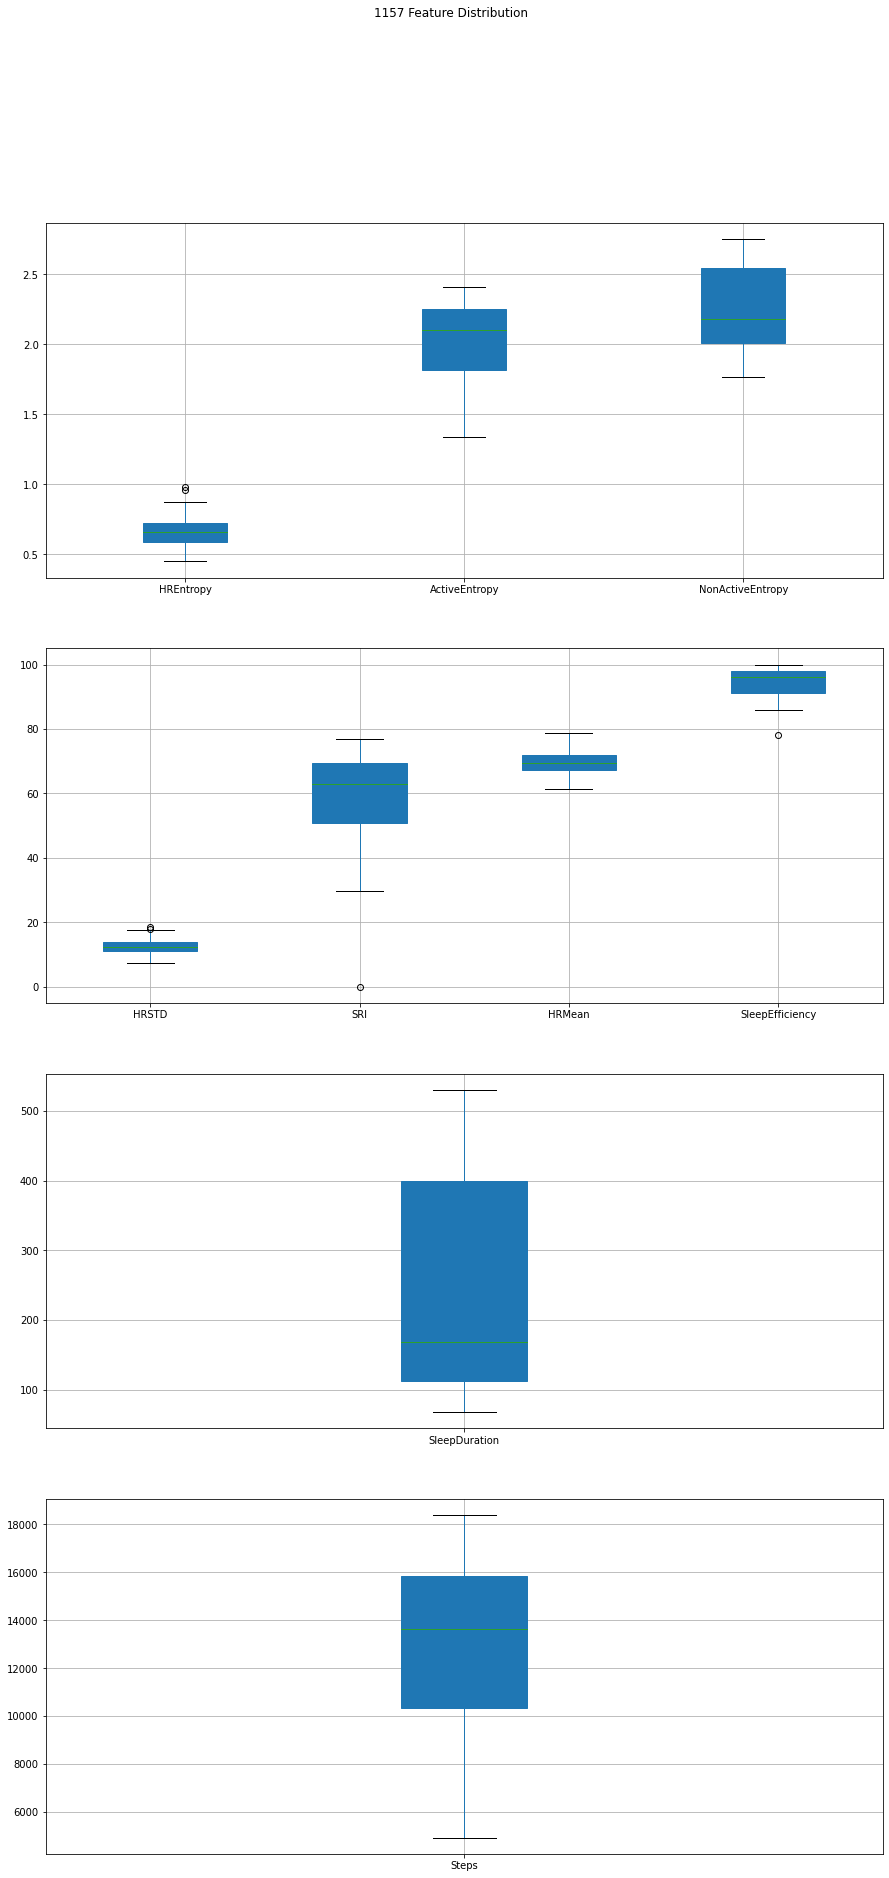

In [32]:
# Can change index of participants to view each distribution
user = participants[0]

# Make smaller data frame containing features for only specified user
uf = fitbit_feat.loc[fitbit_feat['User'] == user, ['HREntropy', 'ActiveEntropy', 'NonActiveEntropy', 'HRSTD', 'SRI', 'HRMean', 'SleepEfficiency', 'SleepDuration', 'Steps']]
fig, axs = plt.subplots(4,1, figsize=(15,30))
plt.suptitle(str(user) + ' Feature Distribution')
for feat in ['HREntropy', 'ActiveEntropy', 'NonActiveEntropy', 'HRSTD', 'SRI', 'HRMean', 'SleepEfficiency', 'SleepDuration', 'Steps']:
    uf[feat] = uf[feat].astype('float64')
    
# Split features up by magnitude so axis is similar
uf.boxplot(column= ['HREntropy', 'ActiveEntropy', 'NonActiveEntropy'], ax = axs[0], patch_artist=True)
uf.boxplot(column= ['HRSTD', 'SRI', 'HRMean', 'SleepEfficiency'], ax = axs[1],patch_artist=True)
uf.boxplot(column= ['SleepDuration'], ax=axs[2],patch_artist=True)
uf.boxplot(column=['Steps'], ax=axs[3],patch_artist=True)
plt.show()

## Survey Features for batch 3 and 4

In [33]:
# Function that will subtract a day from date, needed because survey dataframe shows previous days features
def convert_date(date_string):
    date0 = datetime.datetime.strptime(date_string, '%Y/%m/%d')
    subtract_day = datetime.timedelta(1)
    new_date = date0 - subtract_day
    return new_date.date()

In [34]:
# Survey features from batch 3/4 come from Han's dataframe
han_df = pd.read_csv('/Users/giabraddock/compwell/WellbeingData_20210214/WellbeingData_20210214_labels.csv', header=0)
# Subtract Day from Date
han_df.update(han_df.loc[:,'date'].apply(convert_date))

In [35]:
# Available data from Han, not all features will be used
han_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 80 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         466 non-null    int64  
 1   u_id                       466 non-null    int64  
 2   job                        466 non-null    object 
 3   date                       466 non-null    object 
 4   recorded_time              466 non-null    object 
 5   valid_eve                  466 non-null    int64  
 6   valid_morn                 466 non-null    int64  
 7   valid_shift                466 non-null    int64  
 8   valid_fitbit               466 non-null    int64  
 9   steps                      466 non-null    int64  
 10  steps_sedentary            466 non-null    int64  
 11  steps_lightly              466 non-null    int64  
 12  steps_moderately           466 non-null    int64  
 13  steps_very                 466 non-null    int64  

In [36]:
# Function to calculate nap duration in minutes, batch 3/4 fitbit did not account for naps
def nap_duration(start_date, end_date):
    if isinstance(start_date, float) or isinstance(end_date, float):
        return 0
    start = datetime.datetime.strptime(start_date[0:-4], '%H:%M:%S')
    end = datetime.datetime.strptime(end_date[0:-4], '%H:%M:%S')
    difference = end - start
    return difference.seconds//60

**Features to extract are: 'NumberofNaps', 'NapDuration', 'CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening'**

In [37]:
# Going to extract 20 features from Han's DF

# Initialize two data frames, separate nap features as some fitbit data contains nap information
# If we want to add this type of nap fitbit features in the future it may be helpful to split those manually recorded and calculate by fitbit
survey_feat = pd.DataFrame([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], columns = ['User', 'Date', 'CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening'])
nap_feat = pd.DataFrame([[0,0,0,0]], columns = ['User', 'Date','NumberofNaps', 'NapDuration'])

for idx, row in han_df.iterrows():
    # Get all features
    date = row['date'].strftime('%Y-%m-%d')
    user = str(row['u_id'])
    
    # Naps
    number_of_naps = row['naps']
    nap1_duration = nap_duration(row['nap1_start'], row['nap1_end'])
    nap2_duration = nap_duration(row['nap2_start'], row['nap2_end'])
    nap3_duration = nap_duration(row['nap3_start'], row['nap3_end'])
    
    # Caffeine, Alcohol, Wake Type, Time to Fall Asleep, Shift Hours
    caf = row['caffeine_cups']
    alc = row['alcohol']
    wake_type = row['awake_type']
    fall_asleep = row['fallsleep_time']
    work_time = row['shift_hours']
    
    # Wellbeing features
    alertm = row['alterness_morning']
    alerte = row['alertness_evening']
    happym = row['happiness_morning']
    happye = row['happiness_evening']
    energym = row['energy_morning']
    energye = row['energy_evening']
    healthm = row['health_morning']
    healthe = row['health_evening']
    relaxm = row['relax_morning']
    relaxe = row['relax_evening']
    
    # Overwork time is any shift that lasts longer than 8 hours, feature table shows overtime in minutes
    if work_time > 8:
        overwork = (work_time - 8)*60
    else:
        overwork = 0
    
    # All nighters  (No Sleep), Shift
    nosleep = row['no_sleep']
    shift = row['shift']
    # 9 is not a shift key in the data
    if shift == 9.0:
        shift = 0
        
    # Separate nap data frame so we don't create extra nap columns when merging data frames
    df1 = pd.DataFrame([[user, date, number_of_naps, (nap1_duration + nap2_duration + nap3_duration)]], columns = ['User', 'Date', 'NumberofNaps', 'NapDuration'])
    
    # df0 contains all other features
    df0 = pd.DataFrame([[user, date, caf, alc, wake_type, fall_asleep, work_time, overwork, nosleep, shift, alertm, alerte, happym, happye, energym, energye, healthm, healthe, relaxm, relaxe]], columns = ['User', 'Date', 'CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening'])
    survey_feat = pd.concat([survey_feat, df0], ignore_index=True)
    nap_feat = pd.concat([nap_feat, df1], ignore_index=True)

# Drop row of zeros    
survey_feat.drop([0], inplace=True)
nap_feat.drop([0], inplace=True)

,User,Date,CupsofCaffeine,AlcoholicDrinks,WakeMethod(0-2),TimeToFallAsleep(0-5),HoursWorked,OverTime(Mins),NoSleep,ShiftType,AlertnessMorning,AlertnessEvening,HappinessMorning,HappinessEvening,EnergyMorning,EnergyEvening,HealthMorning,HealthEvening,RelaxMorning,RelaxEvening
1,1001,2020-10-23,3,0,2,0,8,0,1,3.0,36,0,21,0,31,0,32,0,64,0
2,1001,2020-10-24,0,0,0,0,8,0,1,1.0,0,70,0,70,0,77,0,73,0,74
3,1001,2020-10-25,3,0,2,0,8,0,1,1.0,20,38,30,34,29,39,17,36,30,20
4,1001,2020-10-26,0,0,0,0,8,0,1,1.0,0,30,0,32,0,13,0,66,0,66
5,1001,2020-10-27,3,0,2,0,0,0,1,NaN,32,27,31,71,31,73,67,35,62,70


In [38]:
# Remove 1001 and 1002, as features are from later batch
drop1001 = []
for i, r in survey_feat.iterrows():
    if r['User'] == '1001' or r['User'] == '1002':
        drop1001.append(i)
survey_feat.drop(drop1001, inplace=True)
survey_feat.User.value_counts()

1103    41
1102    37
1115    35
1105    35
1153    31
1155    30
1154    30
1151    27
1150    24
1108    21
1157    17
1156    15
1114    10
1158     9
Name: User, dtype: int64

In [40]:
# Add survey features to fitbit table
feature_table = survey_feat.merge(fitbit_feat, how = 'outer', on=['User', 'Date'])

In [41]:
# Add nap data
for i, r in nap_feat.iterrows():
    feature_table.loc[(feature_table['User'] == r['User']) & (feature_table['Date'] == r['Date']), ['NumberofNaps', 'NapDuration']] = [r['NumberofNaps'], r['NapDuration']]

## Survey Features batch 1 survey (commented out due to lack of JBS data)

In [43]:
# batch1_survey = pd.read_csv('/Users/giabraddock/compwell/merged_data2.csv', header=0)
# batch1_survey.info()

In [44]:
# # Going to extract 18 features from merged csv 2
# survey_feat2 = pd.DataFrame([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], columns = ['User', 'Date', 'CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening'])
# for idx, row in batch1_survey.iterrows():
#     # Get all features
#     date = '2' + row['date'][1:]
#     user = str(row['userid'])
#     # Caffeine Cups
#     if row['numCaff_3.0']:
#         caf = 3
#     elif row['numCaff_2.0']:
#         caf = 2
#     elif row['numCaff_1.0']:
#         caf = 1
#     elif row['numCaff_0.0']:
#         caf = 0
#     else:
#         caf = None
#     alc = row['AlcoDrugMedi']
#     # Wake Method
#     if row['awakeType_0.0']:
#         wake_type = 0
#     elif row['awakeType_1.0']:
#         wake_type = 1
#     elif row['awakeType_2.0']:
#         wake_type = 2
#     else:
#         wake_type = None
#     # Interval of time to fall asleep
#     if row['timeFallSleep_0.0']:
#         fall_asleep = 0
#     elif row['timeFallSleep_1.0']:
#         fall_asleep = 1
#     elif row['timeFallSleep_2.0']:
#         fall_asleep = 2
#     elif row['timeFallSleep_3.0']:
#         fall_asleep = 3
#     elif row['timeFallSleep_4.0']:
#         fall_asleep = 4
#     elif row['timeFallSleep_5.0']:
#         fall_asleep = 5
#     else:
#         fall_asleep = None
#     # Shift type
#     if row['shift1']:
#         shift = 1
#     elif row['shift2']:
#         shift = 2
#     elif row['shift3']:
#         shift = 3
#     else:
#         shift = None
#     work_time = row['totalhour']
#     alertm = row['alterness_morning']
#     alerte = row['alertness_evening']
#     happym = row['happiness_morning']
#     happye = row['happiness_evening']
#     energym = row['energy_morning']
#     energye = row['energy_evening']
#     healthm = row['health_morning']
#     healthe = row['health_evening']
#     relaxm = row['relax_morning']
#     relaxe = row['relax_evening']
#     overwork = row['overworkTime']
#     nosleep = row['noSleep']
#     # Add each row of features to table
#     df0 = pd.DataFrame([[user, date, caf, alc, wake_type, fall_asleep, work_time, overwork, nosleep, shift, alertm, alerte, happym, happye, energym, energye, healthm, healthe, relaxm, relaxe]], columns = ['User', 'Date', 'CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening'])
#     survey_feat2 = pd.concat([survey_feat2, df0], ignore_index=True)
# # Drop row of zeros added in initialization 
# survey_feat2.drop([0], inplace=True)
# survey_feat2.head()

In [45]:
# # Add survey features to fitbit table
# for i, r in survey_feat2.iterrows():
#     feature_table.loc[(feature_table['User'] == r['User']) & (feature_table['Date'] == r['Date']), ['CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']] = [r['CupsofCaffeine'], r['AlcoholicDrinks'], r['WakeMethod(0-2)'], r['TimeToFallAsleep(0-5)'], r['HoursWorked'], r['OverTime(Mins)'], r['NoSleep'], r['ShiftType'], r['AlertnessMorning'], r['AlertnessEvening'], r['HappinessMorning'], r['HappinessEvening'], r['EnergyMorning'], r['EnergyEvening'], r['HealthMorning'], r['HealthEvening'], r['RelaxMorning'], r['RelaxEvening']]

In [46]:
# feature_table.drop_duplicates(inplace=True)

## Survey Features for batch 1

In [57]:
batch5 = ['1160', '1161', '1164', '1165', '1167', '1168', '1171', '1173']
summary = pd.DataFrame()

# Survey feture info comes from a different file for each participant
for p in batch5:
    summary_file = glob.glob('/Users/giabraddock/compwell/batch5/Summary_and_prediction/summaries_{}*.csv'.format(p))
    summary0 = pd.read_csv(summary_file[0], header=0)
    summary = pd.concat([summary, summary0], axis=0)

In [58]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280 entries, 0 to 34
Data columns (total 80 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         280 non-null    int64  
 1   u_id                       280 non-null    int64  
 2   job                        280 non-null    object 
 3   date                       280 non-null    object 
 4   recorded_time              280 non-null    object 
 5   valid_eve                  280 non-null    int64  
 6   valid_morn                 280 non-null    int64  
 7   valid_shift                280 non-null    int64  
 8   valid_fitbit               280 non-null    int64  
 9   steps                      280 non-null    int64  
 10  steps_sedentary            280 non-null    int64  
 11  steps_lightly              280 non-null    int64  
 12  steps_moderately           280 non-null    int64  
 13  steps_very                 280 non-null    int64  


In [59]:
# Updated function to convert date, different date format for this data
def convert_date2(date_string):
    date0 = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    subtract_day = datetime.timedelta(1)
    new_date = date0 - subtract_day
    return new_date.date()

In [60]:
# Updated function to calculate nap duration in minutes, different time format
def nap_duration2(start_date, end_date):
    if isinstance(start_date, float) or isinstance(end_date, float):
        return 0
    start = datetime.datetime.strptime(start_date, '%H:%M:%S')
    end = datetime.datetime.strptime(end_date, '%H:%M:%S')
    difference = end - start
    return difference.seconds//60

In [61]:
summary.update(summary.loc[:,'date'].apply(convert_date2))

In [62]:
# Going to extract 20 features from batch 5 survey data

# Initialize tables
survey_feat = pd.DataFrame([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]], columns = ['User', 'Date', 'CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening'])
nap_feat = pd.DataFrame([[0,0,0,0]], columns = ['User', 'Date','NumberofNaps', 'NapDuration'])

for idx, row in summary.iterrows():
    # Get all features
    date = row['date'].strftime('%Y-%m-%d')
    user = str(row['u_id'])
    
    # Naps
    number_of_naps = row['naps']
    nap1_duration = nap_duration2(row['nap1_start'], row['nap1_end'])
    nap2_duration = nap_duration2(row['nap2_start'], row['nap2_end'])
    nap3_duration = nap_duration2(row['nap3_start'], row['nap3_end'])
    
    # Caffeine, Alcohol, Wake Method, Time to fall asleep, shift hours
    caf = row['caffeine_cups']
    alc = row['alcohol']
    wake_type = row['awake_type']
    fall_asleep = row['fallsleep_time']
    work_time = row['shift_hours']
    
    # Missing Wellbeing scores automatically added as 0, need to replace with NaN
    alertm = row['alterness_morning']
    if alertm == 0:
        alertm = np.float('nan')
    alerte = row['alertness_evening']
    if alerte == 0:
        alerte = np.float('nan')
    happym = row['happiness_morning']
    if happym == 0:
        happym = np.float('nan')
    happye = row['happiness_evening']
    if happye == 0:
        happye = np.float('nan')
    energym = row['energy_morning']
    if energym == 0:
        energym = np.float('nan')
    energye = row['energy_evening']
    if energye == 0:
        energye = np.float('nan')
    healthm = row['health_morning']
    if healthm == 0:
        healthm = np.float('nan')
    healthe = row['health_evening']
    if healthe == 0:
        healthe = np.float('nan')
    relaxm = row['relax_morning']
    if relaxm == 0:
        relaxm = np.float('nan')
    relaxe = row['relax_evening']
    if relaxe == 0:
        relaxe = np.float('nan')
        
    # Overwork time is any shift that lasts longer than 8 hours, feature table shows overtime in minutes
    if work_time > 8:
        overwork = (work_time - 8)*60
    else:
        overwork = 0
    nosleep = row['no_sleep']
    shift = row['shift']
    # 9 is not a shift key in the data
    if shift == 9.0:
        shift = 0
        
    # Separate nap data frame so we don't create extra nap columns when merging data frames
    df1 = pd.DataFrame([[user, date, number_of_naps, (nap1_duration + nap2_duration + nap3_duration)]], columns = ['User', 'Date', 'NumberofNaps', 'NapDuration'])
    df0 = pd.DataFrame([[user, date, caf, alc, wake_type, fall_asleep, work_time, overwork, nosleep, shift, alertm, alerte, happym, happye, energym, energye, healthm, healthe, relaxm, relaxe]], columns = ['User', 'Date', 'CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening'])
    survey_feat = pd.concat([survey_feat, df0], ignore_index=True)
    nap_feat = pd.concat([nap_feat, df1], ignore_index=True)
    
# Drop row of zeros
survey_feat.drop([0], inplace=True)
nap_feat.drop([0], inplace=True)
survey_feat.head()

,User,Date,CupsofCaffeine,AlcoholicDrinks,WakeMethod(0-2),TimeToFallAsleep(0-5),HoursWorked,OverTime(Mins),NoSleep,ShiftType,AlertnessMorning,AlertnessEvening,HappinessMorning,HappinessEvening,EnergyMorning,EnergyEvening,HealthMorning,HealthEvening,RelaxMorning,RelaxEvening
1,1160,2021-02-28,1,0,1,1,8,0,1,1.0,22.0,NaN,50.0,NaN,29.0,NaN,100.0,NaN,30.0,NaN
2,1160,2021-03-01,1,0,1,2,8,0,1,2.0,11.0,27.0,50.0,50.0,17.0,36.0,30.0,50.0,20.0,50.0
3,1160,2021-03-02,1,0,1,0,8,0,1,1.0,14.0,22.0,50.0,50.0,18.0,24.0,44.0,50.0,48.0,41.0
4,1160,2021-03-03,1,0,1,1,0,0,1,NaN,28.0,28.0,50.0,68.0,13.0,33.0,20.0,50.0,35.0,70.0
5,1160,2021-03-04,1,0,1,2,8,0,1,2.0,50.0,34.0,50.0,50.0,43.0,12.0,44.0,7.0,50.0,50.0


In [64]:
# Add features to table
for i, r in survey_feat.iterrows():
     feature_table.loc[(feature_table['Date'] == r['Date']) & (feature_table['User'] == r['User']) , ['CupsofCaffeine', 'AlcoholicDrinks', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'HoursWorked', 'OverTime(Mins)', 'NoSleep', 'ShiftType', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']] = [r['CupsofCaffeine'], r['AlcoholicDrinks'], r['WakeMethod(0-2)'], r['TimeToFallAsleep(0-5)'], r['HoursWorked'], r['OverTime(Mins)'], r['NoSleep'], r['ShiftType'], r['AlertnessMorning'], r['AlertnessEvening'], r['HappinessMorning'], r['HappinessEvening'], r['EnergyMorning'], r['EnergyEvening'], r['HealthMorning'], r['HealthEvening'], r['RelaxMorning'], r['RelaxEvening']]

In [65]:
# Add nap data
for i, r in nap_feat.iterrows():
    feature_table.loc[(feature_table['User'] == r['User']) & (feature_table['Date'] == r['Date']), ['NumberofNaps', 'NapDuration']] = [r['NumberofNaps'], r['NapDuration']]

In [ ]:
# Need to make sure we didn't add survey data that extends beyond the study's 5-week period
dropi = []

# If User, Date combo is not in fitbit table, drop the row
for idx, r in feature_table.iterrows():
    u = r['User']
    date = r['Date']
    if u not in fitbit_feat.loc[:,'User'].values:
        dropi.append(idx)
    elif date not in fitbit_feat.loc[fitbit_feat['User']==u, 'Date'].values:
        dropi.append(idx)
        
# Clean feature table
feature_table.drop(dropi, inplace=True)
feature_table.User.value_counts()

## Summary Statistics for Survey Features

In [72]:
# Mean and Standard Deviation of Variables, some variables are categorical so the analysis is limited
survey_mean = feature_table.loc[:,['NumberofNaps','NapDuration', 'CupsofCaffeine', 'AlcoholicDrinks', 'HoursWorked', 'OverTime(Mins)', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']].mean()
survey_std = feature_table.loc[:,['NumberofNaps','NapDuration','CupsofCaffeine', 'AlcoholicDrinks', 'HoursWorked', 'OverTime(Mins)', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']].std()
survey_summary = pd.concat([survey_mean, survey_std], axis = 1)
survey_summary.columns = ['Mean', 'Standard Deviation']
survey_summary

,Mean,Standard Deviation
NumberofNaps,0.426108,0.603044
NapDuration,95.330049,226.990367
CupsofCaffeine,0.857143,1.015575
AlcoholicDrinks,0.174877,0.503282
HoursWorked,4.334975,3.990867
OverTime(Mins),0.000000,0.000000
AlertnessMorning,40.150895,25.549655
AlertnessEvening,36.146530,23.694286
HappinessMorning,49.987212,24.005712
HappinessEvening,50.627249,25.532219


**Summary Statistics for Categorical Variables**

In [73]:
# Wake Method (Natural, Alarm, Other)
vals = feature_table.loc[:,['WakeMethod(0-2)']].value_counts()
total = feature_table.loc[:,['WakeMethod(0-2)']].count().values[0]

# Only need the first two digits
wmt_string0 = str(vals.values[0]/total)[2:4] +'%' 
wmt_string1 = str(vals.values[1]/total)[2:4] +'%' 
wmt_string2 = str(vals.values[2]/total)[2:4] +'%'
idx = [str(x)[1:2] for x in list(vals.index)]
wmt = pd.DataFrame([wmt_string0, wmt_string1, wmt_string2], columns = ['WakeMethod(0-2)'])
wmt.set_index(pd.Index(list(vals.index)), inplace=True)
wmt

,WakeMethod(0-2)
0.0,55%
1.0,31%
2.0,13%


In [74]:
# Shift Type/Number
vals = feature_table.loc[:,['ShiftType']].value_counts()
total = feature_table.loc[:,['ShiftType']].count().values[0]
stt_string0 = str(vals.values[0]/total)[2:4] +'%' 
stt_string1 = str(vals.values[1]/total)[2:4] +'%' 
stt_string2 = str(vals.values[2]/total)[2:4] +'%'
stt_string3 = str(vals.values[3]/total)[2:4] + '%'
idx = [str(x)[1:2] for x in list(vals.index)]
stt = pd.DataFrame([stt_string0, stt_string1, stt_string2, stt_string3], columns = ['ShiftType'])
stt.set_index(pd.Index(list(vals.index)), inplace=True)
stt

,ShiftType
1.0,34%
2.0,34%
3.0,29%
0.0,02%


In [75]:
# Time to Fall Asleep
vals = survey_feat.loc[:,['TimeToFallAsleep(0-5)']].value_counts()
total = survey_feat.loc[:,['TimeToFallAsleep(0-5)']].count().values[0]
tts0 = str(vals.values[0]/total)[2:4] +'%' 
tts1 = str(vals.values[1]/total)[2:4] +'%' 
tts2 = str(vals.values[2]/total)[3:4] +'%'
tts3 = str(vals.values[3]/total)[3:4] +'%'
tts4 = str(vals.values[4]/total)[3:4] +'%'
tts = pd.DataFrame([tts0, tts1, tts2, tts3, tts4], columns = ['TimeToFallAsleep(0-5)'])
tts.set_index(pd.Index(list(vals.index)), inplace=True)
tts

,TimeToFallAsleep(0-5)
0,37%
1,31%
2,8%
3,7%
4,4%


**Graphs of Summary Statistics**

In [154]:
participants = list(fitbit_feat.User.value_counts().index)

<ipython-input-76-1999b60f206e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uf['NapDuration'] = uf['NapDuration'].astype('float64')


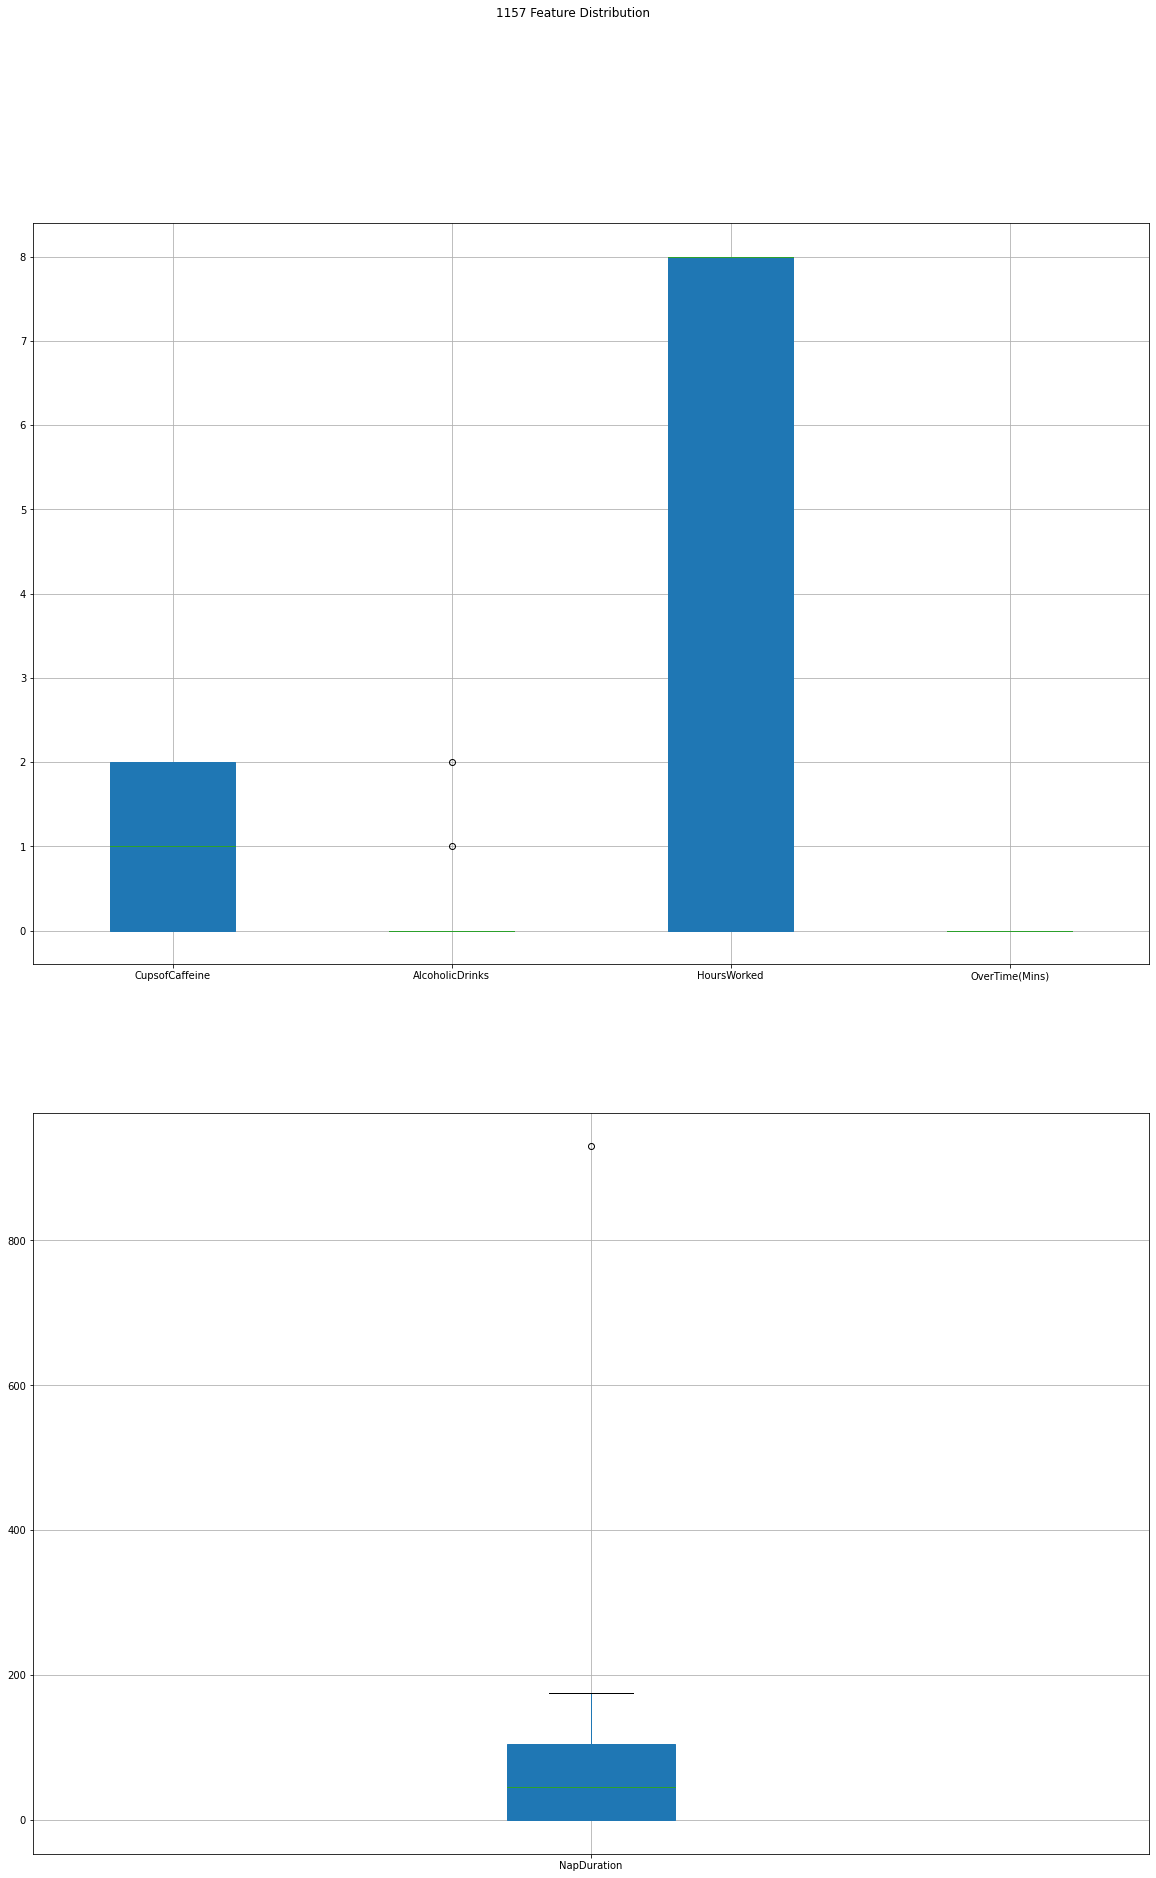

In [76]:
# Can plot the distribution for each participant by changing index of participants
user = participants[0]

uf = feature_table.loc[feature_table['User'] == user]
fig, axs = plt.subplots(2,1, figsize=(20,30))
plt.suptitle(str(user) + ' Feature Distribution')

# Different plots for different features based on their magnitude
uf.boxplot(column= ['CupsofCaffeine', 'AlcoholicDrinks', 'HoursWorked', 'OverTime(Mins)'], ax = axs[0], patch_artist=True)
uf['NapDuration'] = uf['NapDuration'].astype('float64')
uf.boxplot(column= ['NapDuration'], ax=axs[1], patch_artist=True)
plt.show()

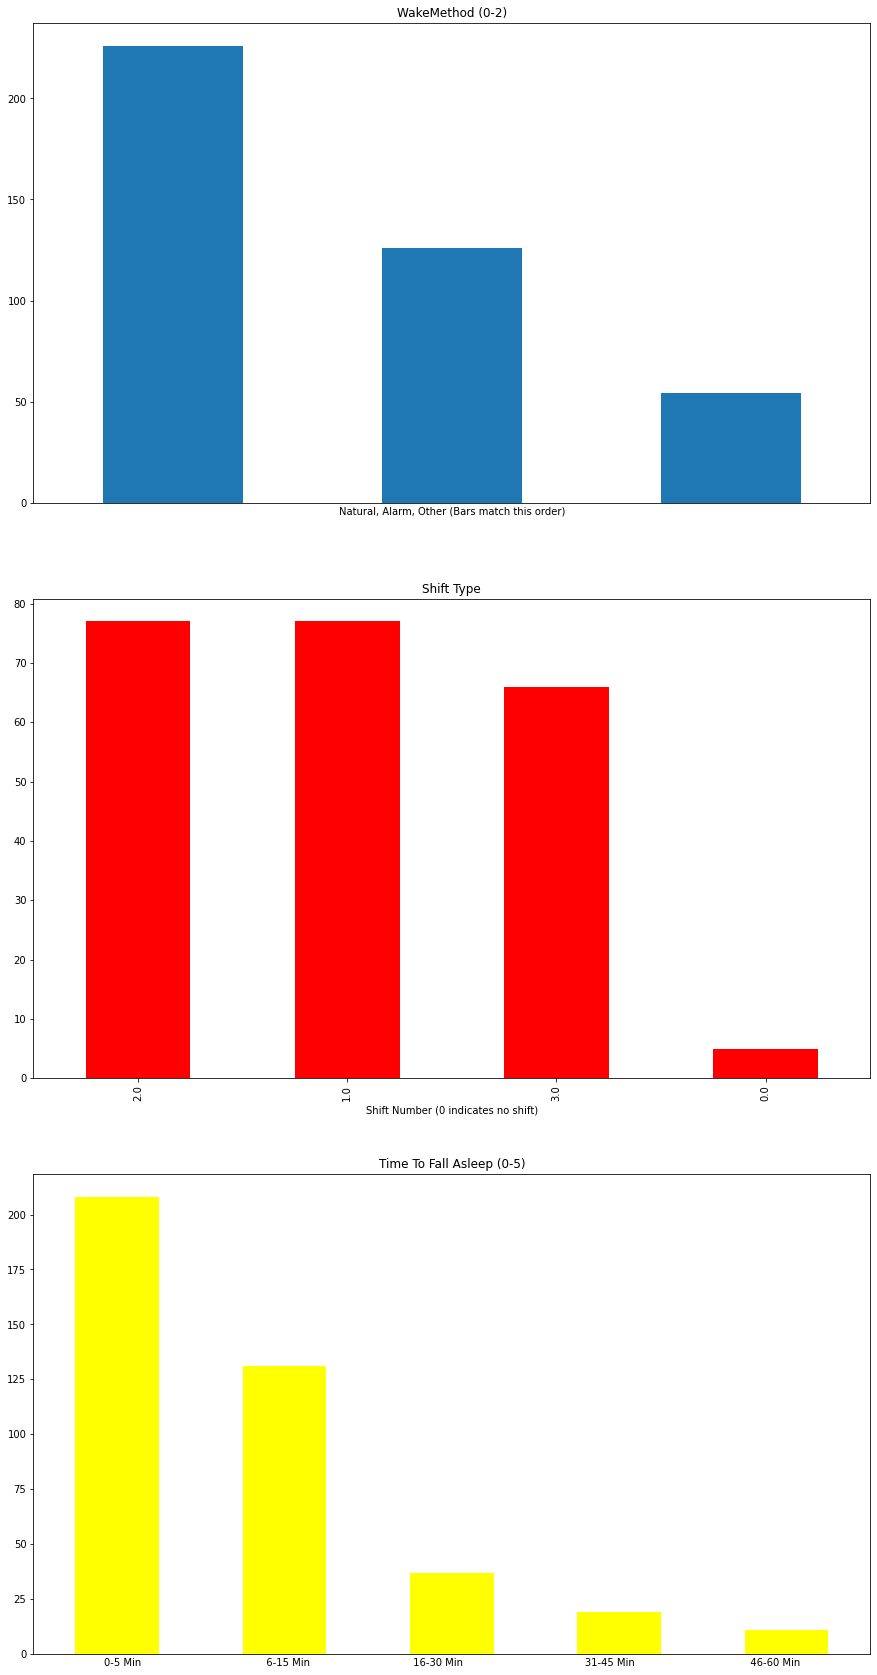

In [77]:
# Plot Categorical variables
fig, axs = plt.subplots(3,1, figsize=(15,30))
feature_table['WakeMethod(0-2)'].value_counts().plot(kind='bar', ax=axs[0], title='WakeMethod (0-2)', xticks=[], xlabel = 'Natural, Alarm, Other (Bars match this order)')
feature_table['ShiftType'].value_counts().plot(kind='bar', color='red', ax=axs[1], title='Shift Type', xlabel = 'Shift Number (0 indicates no shift)')
feature_table['TimeToFallAsleep(0-5)'].value_counts().plot(kind='bar', color='yellow', ax=axs[2], title='Time To Fall Asleep (0-5)', xticks=[], xlabel= '0-5 Min                                        6-15 Min                                 16-30 Min                                       31-45 Min                                     46-60 Min')
plt.show()

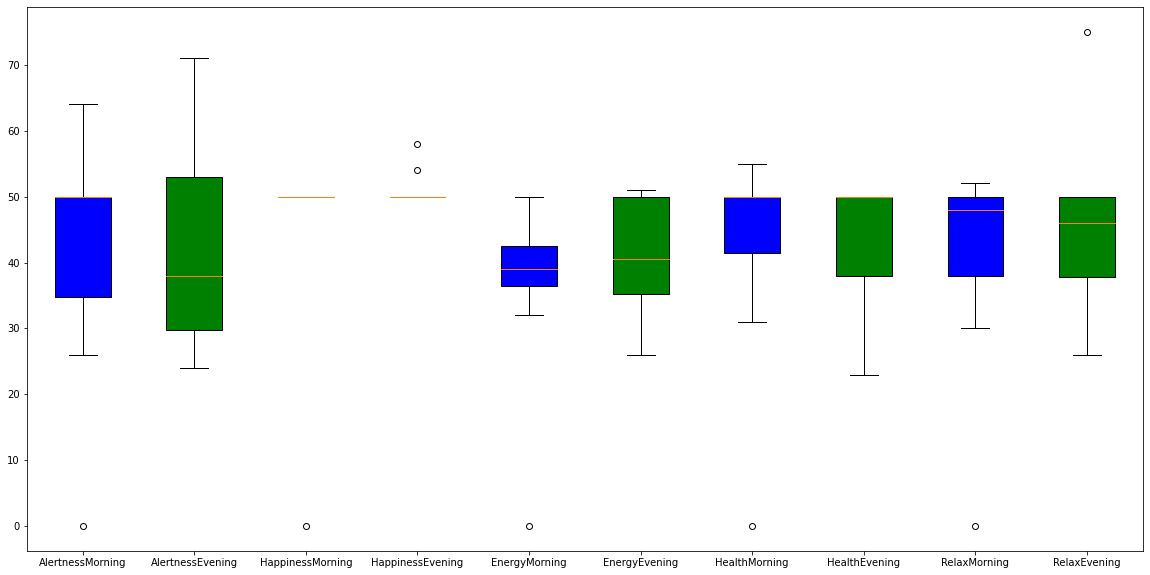

In [78]:
# For Wellbeing features set distribution boxplots to different colors to distinguish between morning and evening
fig = plt.figure(figsize= (20,10))
feat_dict = {}
colors = ['blue', 'green', 'blue', 'green','blue', 'green', 'blue', 'green', 'blue', 'green']
for f in ['AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']:
    feat_dict[f] = [x for x in list(uf.loc[:, f].values) if str(x) != 'nan']
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

## Look at High vs. Low Risk Burnout Participants

In [80]:
# Burnout scale info for batch 3/4, no batch 1 jbs information
jbs1 = pd.read_csv('/Users/giabraddock/compwell/CompWell_REU2021/jbs_table.csv')

# Burnout scale info for batch 5
jbs5 = pd.read_csv('jbsbatch5.csv', header=0)

In [83]:
# Combine jbs data
jbs1.drop([4,5], inplace=True)
jbs = jbs1.drop(range(0,24,2))
jbs = pd.concat([jbs, jbs5], axis = 0)

In [84]:
# only leave scores in jbs table
jbs.drop(['Unnamed: 0', 'id', 'recorded_time', 'start_time',
       'end_time', 'duration', 'ip_address', 'finished', 'Q1', 'Q2', 'Q3',
       'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14',
       'Q15', 'Q16', 'Q17'], axis = 1, inplace=True)

In [85]:
jbs.reset_index(drop=True, inplace=True)

In [86]:
# Want to see how many participants are above the JBS-D cutoff score 
# Made a set because a participant may fall above on the pre and post survey
highrisk_d = set()
for i, row in jbs.loc[:, ['u_id', 'score_d']].iterrows():
    if row['score_d'] >= 2.06:
        highrisk_d.add(str(row['u_id'])[0:4])
# Want to see how many participants are above the JBS-E cutoff score 
highrisk_e = set()
for i, row in jbs.loc[:, ['u_id', 'score_e']].iterrows():
    if row['score_e'] >= 3.2:
        highrisk_e.add(str(row['u_id'])[0:4])
# Want to see how many partipants are above the JBS-PA cutoff score
highrisk_pa = set()
for i, row in jbs.loc[:, ['u_id', 'score_pa']].iterrows():
    if row['score_pa'] >= 3.51:
        highrisk_pa.add(str(row['u_id'])[0:4])

In [87]:
# All 13 users with jbs info
print(jbs.u_id.unique(), len(jbs.u_id.unique()))

[1153 1102 1103 1151 1108 1158 1155 1115 1154 1150 1157 1156 1160 1161
 1164 1165 1167 1168 1171 1173] 20


In [88]:
# 8 highrisk JBS-D
print(highrisk_d, len(highrisk_d))
# 9 highrisk JBS-E
print(highrisk_e, len(highrisk_e))
# 3 highrisk JBS-PA
print(highrisk_pa, len(highrisk_pa))

{'1108', '1151', '1168', '1167', '1154', '1157', '1173', '1160', '1153', '1102', '1164'} 11
{'1108', '1168', '1171', '1154', '1157', '1173', '1160', '1153', '1103', '1164', '1150'} 11
{'1103', '1151'} 2


In [89]:
# Change columns to keep previous format
jbs.rename(columns={'u_id':'User', 'date': 'Date'}, inplace=True)

In [90]:
# Add JBS scores to feature_table
# Start by making a dictionary storing all scores, store max of pre and post score
score_dict = defaultdict(lambda: defaultdict(int))
jbs['User'] = jbs['User'].astype('str')
for i, r in jbs.iterrows():
    score_dict[r['User']] = [max(jbs.loc[jbs['User'] == r['User'], 'score_e'].values), max(jbs.loc[jbs['User'] == r['User'], 'score_d'].values), max(jbs.loc[jbs['User'] == r['User'], 'score_pa'].values)]

# Copy feature table
ft_risk = feature_table.copy()

# Beacuse many users don't have JBS data, set all scores to NaN
ft_risk['EScore'] = np.nan
ft_risk['DScore'] = np.nan
ft_risk['PAScore'] = np.nan

# Add JBS scores where relevant
no_jbs = []
for i, r in ft_risk.iterrows():
    user = r['User']
    if user in score_dict.keys():
        [e, d, pa] = score_dict[user]
        ft_risk.loc[i,'EScore'] = e
        ft_risk.loc[i,'DScore'] = d
        ft_risk.loc[i,'PAScore'] = pa
    else:
        no_jbs.append(i)
        
ft_risk.drop(no_jbs, inplace=True)

In [91]:
# Sort table by increasing E score values, makes a gradient from least to most at risk of burnout
# Note that individuals without data will be at the end of the frame
ft_risk.sort_values(by='EScore', inplace=True)
# 1003 is the least at risk based on E score and 1108 is the most at risk
print(ft_risk.User.unique())

['1165' '1155' '1161' '1151' '1156' '1158' '1115' '1102' '1153' '1103'
 '1150' '1164' '1160' '1157' '1154' '1108']


In [92]:
# Get feature table for entries with PA scores above the cutoff
hfpa = ft_risk.loc[ft_risk['PAScore'] >= 3.51]
# Get feature table for entries with E scores above the cutoff
hfe = ft_risk.loc[ft_risk['EScore'] >= 3.27]
# Get feature table for entries with D scores above the cutoff
hfd = ft_risk.loc[ft_risk['DScore'] >= 2.06]
# Combine tables and drop duplicates
highrisk = pd.concat([hfpa, hfe, hfd], join='inner')
highrisk.drop_duplicates(inplace=True, ignore_index=True)
highrisk.User.unique()

array(['1151', '1103', '1150', '1164', '1160', '1157', '1154', '1108',
       '1102', '1153'], dtype=object)

In [93]:
# Get lowrisk individuals, only 2 not at risk for any burnout: 1159 and 1156
lowrisk = ft_risk.loc[(ft_risk['User'].isin(highrisk['User'])==False) & (ft_risk['User'].isin(jbs.User))]
lowrisk.User.unique()

array(['1165', '1155', '1161', '1156', '1158', '1115'], dtype=object)

**Plot features for highrisk vs. lowrisk participants**

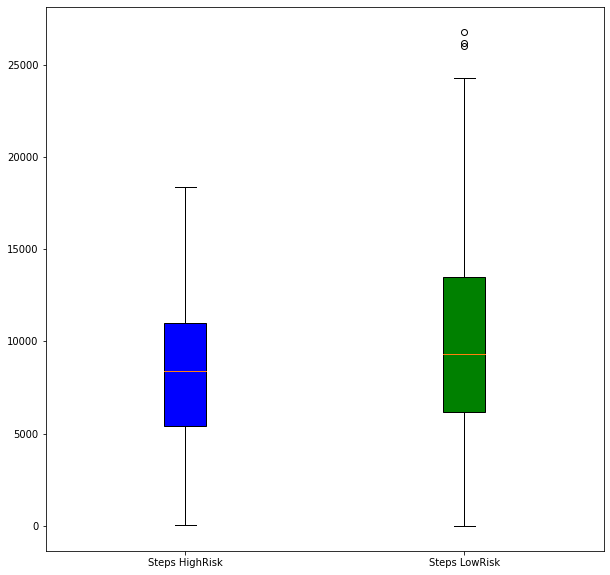

In [94]:
# Start with features with the highest magnitude 
fig = plt.figure(figsize= (10,10))
feat = 'Steps'
hr = [x for x in list(highrisk.loc[:, feat].values) if str(x) != 'nan']
lr = [x for x in list(lowrisk.loc[:, feat].values) if str(x) != 'nan']
feat_dict = {'Steps HighRisk' :hr, 'Steps LowRisk' :lr}
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)

colors = ['blue', 'green', 'blue', 'green','blue', 'green', 'blue', 'green']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
plt.show()

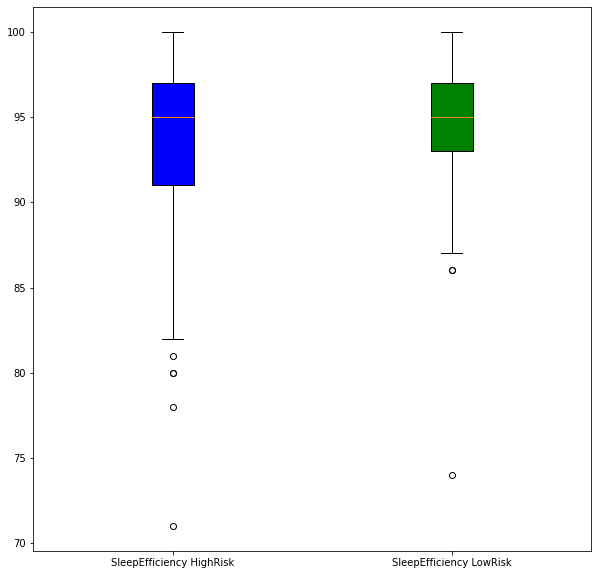

In [151]:
# Features with smaller magnitude
feat = ['SleepEfficiency']
fig = plt.figure(figsize= (10,10))
feat_dict = {}
for f in feat:
    feat_dict[f + ' ' + 'HighRisk'] = [x for x in list(highrisk.loc[:, f].values) if str(x) != 'nan']
    feat_dict[f + ' ' + 'LowRisk'] = [x for x in list(lowrisk.loc[:, f].values) if str(x) != 'nan']
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)

colors = ['blue', 'green', 'blue', 'green']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
plt.show()

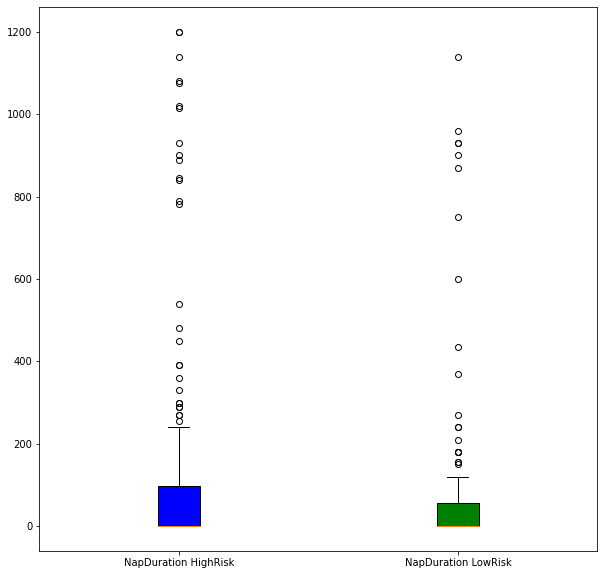

In [96]:
# Features with smaller magnitude
feat = ['NapDuration']
fig = plt.figure(figsize= (10,10))
for f in feat:
    feat_dict = {}
    feat_dict[f + ' ' + 'HighRisk'] = [x for x in list(highrisk.loc[:, f].values) if str(x) != 'nan']
    feat_dict[f + ' ' + 'LowRisk'] = [x for x in list(lowrisk.loc[:, f].values) if str(x) != 'nan']
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)

colors = ['blue', 'green', 'blue', 'green']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
plt.show()

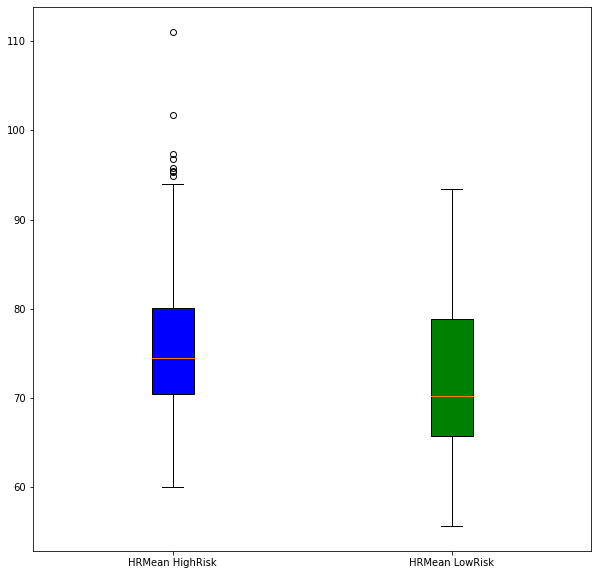

In [149]:
# Smaller magnitude
# feat = ['HRSTD', 'SRI', 'HRMean', 'SleepEfficiency']
feat = ['HRMean']
fig = plt.figure(figsize= (10,10))
feat_dict = {}
for f in feat:
    feat_dict[f + ' ' + 'HighRisk'] = [x for x in list(highrisk.loc[:, f].values) if str(x) != 'nan']
    feat_dict[f + ' ' + 'LowRisk'] = [x for x in list(lowrisk.loc[:, f].values) if str(x) != 'nan']
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)

colors = ['blue', 'green', 'blue', 'green','blue', 'green', 'blue', 'green']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.show()

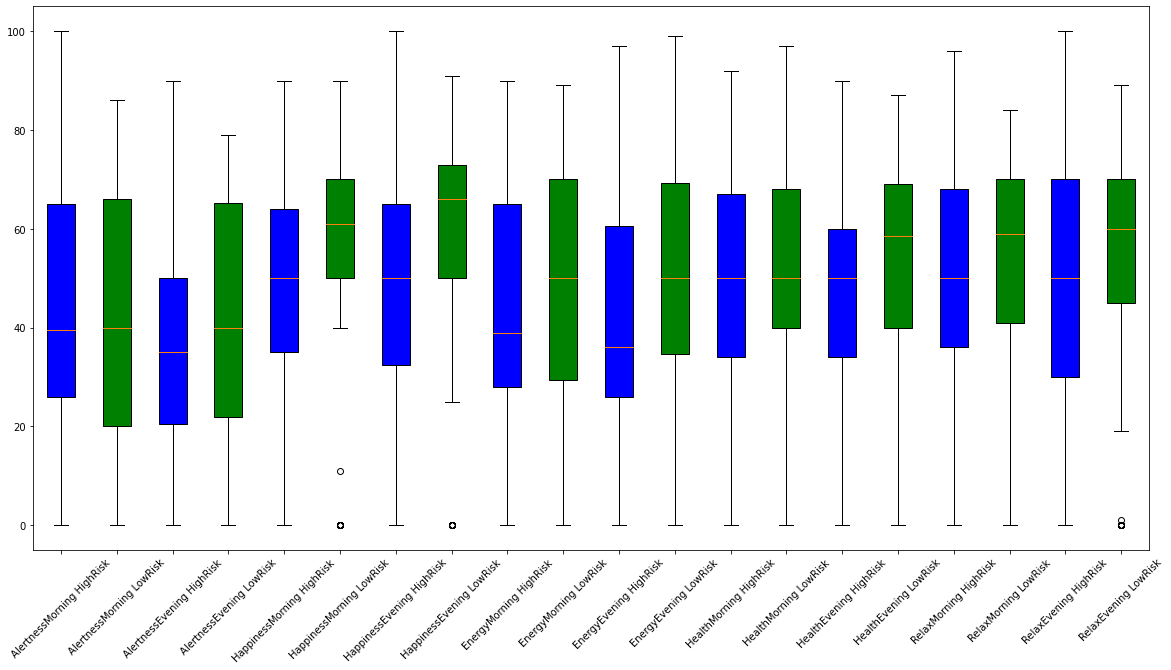

In [98]:
feat = ['AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']
fig = plt.figure(figsize= (20,10))
feat_dict = {}
for f in feat:
    feat_dict[f + ' ' + 'HighRisk'] = [x for x in list(highrisk.loc[:, f].values) if str(x) != 'nan']
    feat_dict[f + ' ' + 'LowRisk'] = [x for x in list(lowrisk.loc[:, f].values) if str(x) != 'nan']
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)

colors = ['blue', 'green', 'blue', 'green','blue', 'green', 'blue', 'green', 'blue', 'green']* 2

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks(rotation = 45)

plt.show()

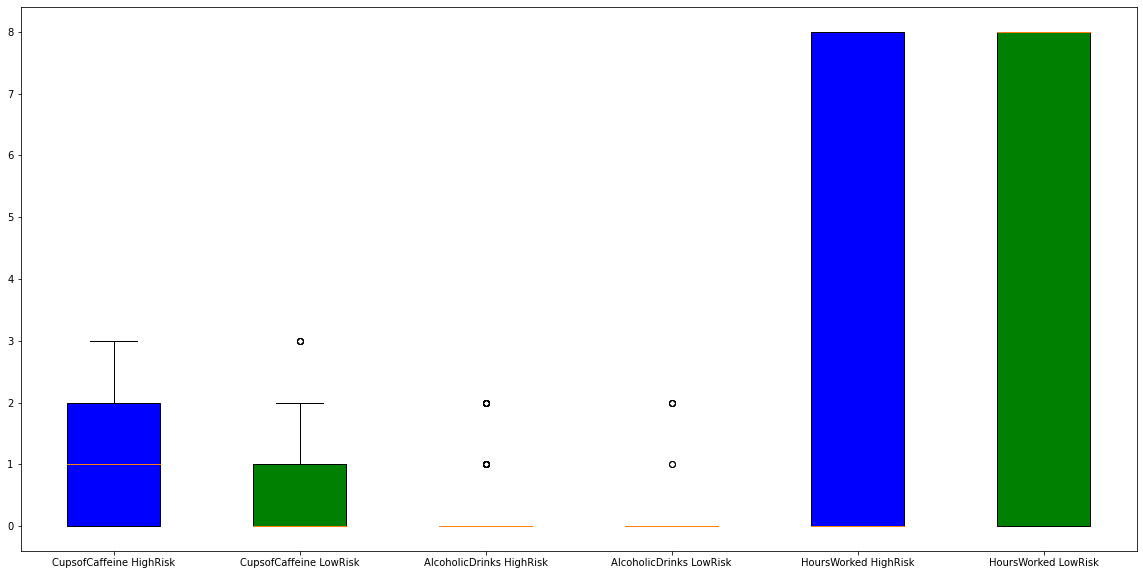

In [99]:
feat = ['CupsofCaffeine', 'AlcoholicDrinks', 'HoursWorked'] 
fig = plt.figure(figsize= (20,10))
feat_dict = {}
for f in feat:
    feat_dict[f + ' ' + 'HighRisk'] = [x for x in list(highrisk.loc[:, f].values) if str(x) != 'nan']
    feat_dict[f + ' ' + 'LowRisk'] = [x for x in list(lowrisk.loc[:, f].values) if str(x) != 'nan']
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)

colors = ['blue', 'green', 'blue', 'green','blue', 'green', 'blue', 'green']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

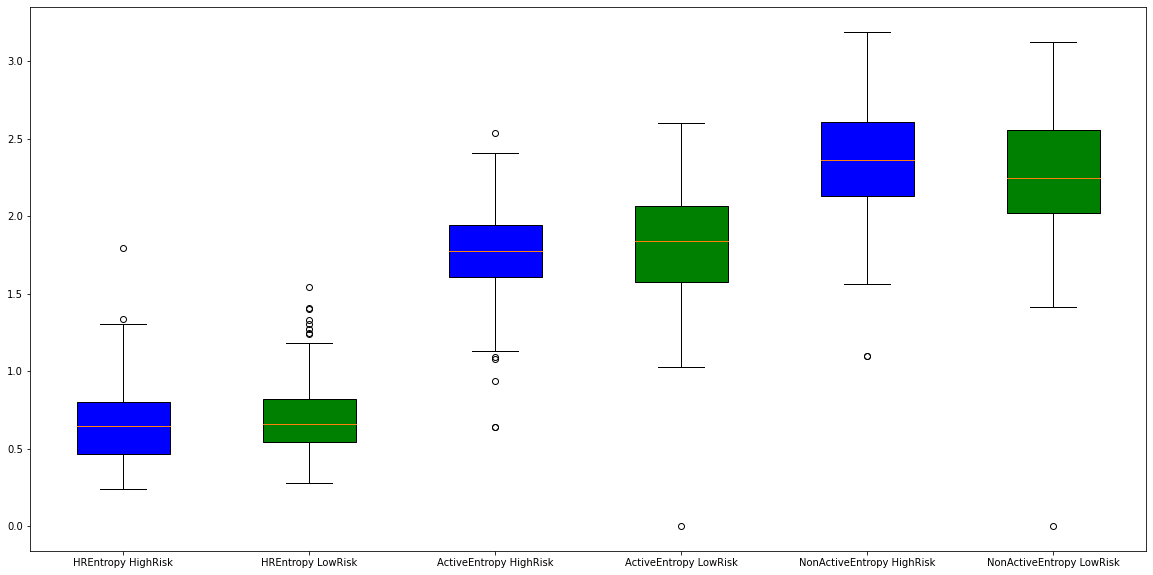

In [100]:
#Took out overtime for axes
feat = ['HREntropy', 'ActiveEntropy', 'NonActiveEntropy']
fig = plt.figure(figsize= (20,10))
feat_dict = {}
for f in feat:
    feat_dict[f + ' ' + 'HighRisk'] = [x for x in list(highrisk.loc[:, f].values) if str(x) != 'nan']
    feat_dict[f + ' ' + 'LowRisk'] = [x for x in list(lowrisk.loc[:, f].values) if str(x) != 'nan']
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)
colors = ['blue', 'green', 'blue', 'green','blue', 'green', 'blue', 'green']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

## Statistical Significance between Burnout Scale and Features

**Start with Continuous Variables**

In [101]:
# Need feature table without any NaN scores
risk_frame = pd.concat([highrisk, lowrisk])

In [ ]:
# Look at distributions of features vs. Scores, look for linearity
features = ['HREntropy','ActiveEntropy','NonActiveEntropy','HRSTD','SRI','HRMean','SleepEfficiency','NapDuration', 'SleepDuration','Steps', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']
for f in features:
    risk_frame[f] = risk_frame[f].astype('float64')
    plt.scatter(risk_frame[f].values, risk_frame['EScore'].values)
    plt.title('JBS-E vs.' + f)
    plt.show()
    plt.scatter(risk_frame[f].values, risk_frame['DScore'].values)
    plt.title('JBS-D vs.' + f)
    plt.show()
    plt.scatter(risk_frame[f].values, risk_frame['PAScore'].values)
    plt.title('JBS-PA vs.' + f)
    plt.show()
# Distributions don't look etremely linear... try correlation anyway?

array([[<AxesSubplot:title={'center':'HREntropy'}>,
        <AxesSubplot:title={'center':'ActiveEntropy'}>,
        <AxesSubplot:title={'center':'NonActiveEntropy'}>,
        <AxesSubplot:title={'center':'HRSTD'}>,
        <AxesSubplot:title={'center':'SRI'}>],
       [<AxesSubplot:title={'center':'HRMean'}>,
        <AxesSubplot:title={'center':'SleepEfficiency'}>,
        <AxesSubplot:title={'center':'NapDuration'}>,
        <AxesSubplot:title={'center':'SleepDuration'}>,
        <AxesSubplot:title={'center':'Steps'}>],
       [<AxesSubplot:title={'center':'AlertnessMorning'}>,
        <AxesSubplot:title={'center':'AlertnessEvening'}>,
        <AxesSubplot:title={'center':'HappinessMorning'}>,
        <AxesSubplot:title={'center':'HappinessEvening'}>,
        <AxesSubplot:title={'center':'EnergyMorning'}>],
       [<AxesSubplot:title={'center':'EnergyEvening'}>,
        <AxesSubplot:title={'center':'HealthMorning'}>,
        <AxesSubplot:title={'center':'HealthEvening'}>,
        <Ax

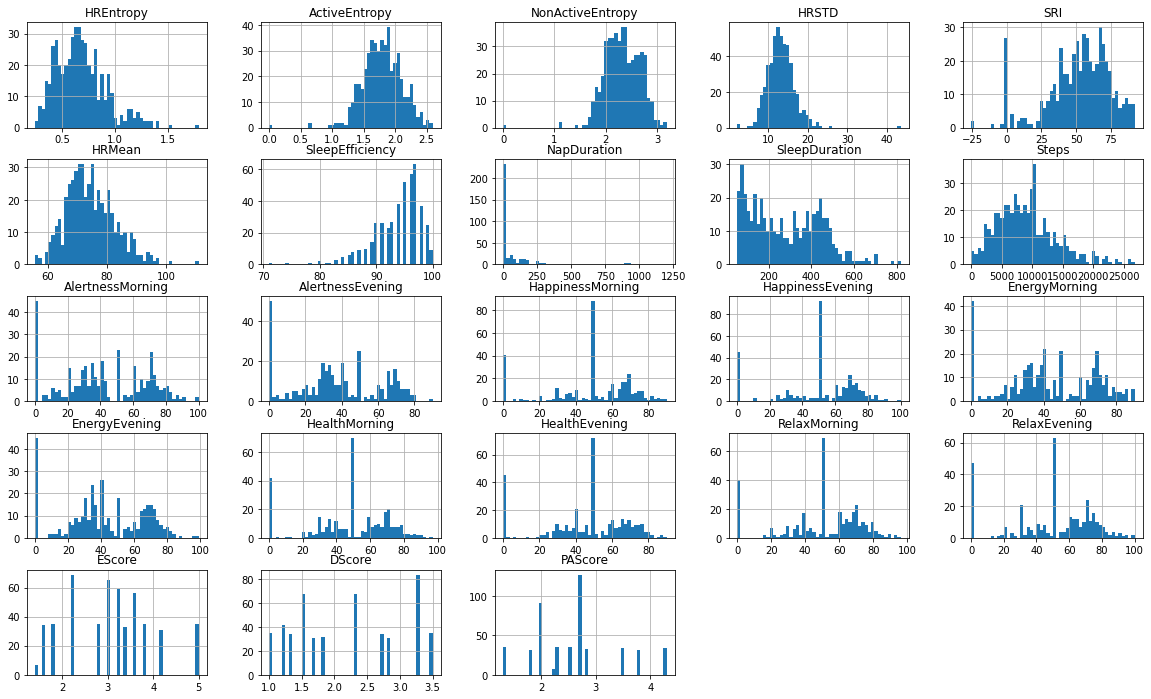

In [103]:
# Look at distributions of features
features2 = ['HREntropy','ActiveEntropy','NonActiveEntropy','HRSTD','SRI','HRMean','SleepEfficiency','NapDuration', 'SleepDuration','Steps', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening','EScore', 'DScore', 'PAScore']
%matplotlib inline
risk_frame.hist(column=features2, bins = 50, figsize=(20,12))

In [104]:
# Empirically test for normal/Gaussian distribution, need to check because it is an assumption of correlation test
norm_feat = []
for f in features2:
    norm = normaltest(risk_frame[f].values,nan_policy='omit')
    if norm[-1] < 0.05:
        print(f + ' is Normal')
        norm_feat.append(f)
    else:
        print(f + ' is not Normal')

HREntropy is Normal
ActiveEntropy is Normal
NonActiveEntropy is Normal
HRSTD is Normal
SRI is Normal
HRMean is Normal
SleepEfficiency is Normal
NapDuration is Normal
SleepDuration is Normal
Steps is Normal
AlertnessMorning is Normal
AlertnessEvening is Normal
HappinessMorning is Normal
HappinessEvening is Normal
EnergyMorning is Normal
EnergyEvening is Normal
HealthMorning is Normal
HealthEvening is Normal
RelaxMorning is Normal
RelaxEvening is Normal
EScore is Normal
DScore is Normal
PAScore is Normal


In [105]:
# Create Correlations table
features = ['HREntropy','ActiveEntropy','NonActiveEntropy','HRSTD','SRI','HRMean','SleepEfficiency','NapDuration', 'SleepDuration','Steps', 'AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']
correlations = pd.DataFrame([[0,0,0,0,0,0]], columns = ['HighRisk Mean', 'LowRisk Mean', 'ANOVA P-Value', 'Pearson Correlation JBS-E', 'Pearson Correlation JBS-D', 'Pearson Correlation JBS-PA'])

# ANOVA test, and correlation tests
for feat in features:
    hr = [x for x in list(highrisk.loc[:, feat].values) if str(x) != 'nan']
    lr = [x for x in list(lowrisk.loc[:, feat].values) if str(x) != 'nan']
    
    # ANOVA one way
    pval = f_oneway(hr,lr)[1]
    pval = round(pval, 4)
    
    # Only perform correlation test on normal distributions
    if feat in norm_feat:
        # Remove NaN
        idxf = ~ np.isnan(risk_frame[feat])
        idxe = ~ np.isnan(risk_frame['EScore'])
        idxd = ~ np.isnan(risk_frame['DScore'])
        idxpa = ~ np.isnan(risk_frame['PAScore'])
        idx = np.logical_and(idxe, idxf)
        corre, _ = pearsonr(risk_frame[feat][idx], risk_frame['EScore'][idx])
        idx = np.logical_and(idxd, idxf)
        corrd, _ = pearsonr(risk_frame[feat][idx], risk_frame['DScore'][idx])
        idx = np.logical_and(idxpa, idxf)
        corrpa, _ = pearsonr(risk_frame[feat][idx], risk_frame['PAScore'][idx])
    else:
        corre = corrd = corrpa = None
    
    # Add to table
    correlations.loc[feat,:] = [mean(hr), mean(lr), pval, corre, corrd, corrpa]

# Correct p values using Benjami Hochberg procedure
corrected = multipletests(pvals=list(correlations['ANOVA P-Value'].values),method='fdr_bh')
correlations['Corrected P-Value'] = corrected[1]

# Drop row of zeros
correlations.drop([0], inplace=True)

In [107]:
correlations.sort_values(by='ANOVA P-Value')

,HighRisk Mean,LowRisk Mean,ANOVA P-Value,Pearson Correlation JBS-E,Pearson Correlation JBS-D,Pearson Correlation JBS-PA,Corrected P-Value
HappinessEvening,45.817814,58.461538,0.0000,-0.201714,-0.282050,0.101699,0.000000
HRMean,75.856862,72.087406,0.0000,0.098056,-0.065555,0.095082,0.000000
Steps,8454.031646,10159.960674,0.0002,-0.020068,-0.155133,-0.163862,0.001050
HappinessMorning,46.020325,55.140187,0.0007,-0.173342,-0.194428,0.120648,0.002940
EnergyEvening,39.340081,48.259615,0.0017,-0.109029,-0.161383,0.006686,0.005400
SleepEfficiency,93.384615,94.719178,0.0018,0.012927,0.091988,-0.287937,0.005400
NonActiveEntropy,2.357363,2.267393,0.0050,-0.086085,-0.055889,0.255527,0.013125
HealthEvening,44.060729,51.451923,0.0062,-0.096906,-0.188704,0.041785,0.014467
HREntropy,0.662636,0.704230,0.0618,-0.273938,-0.142793,0.305775,0.126175
RelaxEvening,47.870445,53.259615,0.0716,-0.065899,-0.136915,0.026969,0.126175


**Categorical variables next**

In [108]:
# Create Correlations table for categorical 
categorical = ['CupsofCaffeine', 'AlcoholicDrinks', 'NumberofNaps', 'HoursWorked', 'WakeMethod(0-2)', 'TimeToFallAsleep(0-5)', 'ShiftType']
catcorr = pd.DataFrame([[0,0,0,0,0,0]], columns = ['HighRisk Mean', 'LowRisk Mean', 'Kruksal Wallis P-Value', 'PBS JBS-E', 'PBS JBS-D', 'PBS JBS-PA'])

# ANOVA test, and correlation tests
for feat in categorical:
    risk_frame[feat] = risk_frame[feat].astype('float64')
    hr = [x for x in list(highrisk.loc[:, feat].values) if str(x) != 'nan']
    lr = [x for x in list(lowrisk.loc[:, feat].values) if str(x) != 'nan']
    
    # Kruskal Wallis, non parametric equivalent to ANOVA
    pval = kruskal(hr,lr, nan_policy='omit')[1]
    pval = round(pval, 4)
    
    # Point biserial for categorical in place of correlation test
    # Remove NaN
    idxf = ~ np.isnan(risk_frame[feat])
    idxe = ~ np.isnan(risk_frame['EScore'])
    idxd = ~ np.isnan(risk_frame['DScore'])
    idxpa = ~ np.isnan(risk_frame['PAScore'])
    idx = np.logical_and(idxe, idxf)
    corre, _ = pointbiserialr(risk_frame[feat][idx], risk_frame['EScore'][idx])
    idx = np.logical_and(idxd, idxf)
    corrd, _ = pointbiserialr(risk_frame[feat][idx], risk_frame['DScore'][idx])
    idx = np.logical_and(idxpa, idxf)
    corrpa, _ = pointbiserialr(risk_frame[feat][idx], risk_frame['PAScore'][idx])
    
    # Add stats to table
    catcorr.loc[feat,:] = [mean(hr), mean(lr), pval, corre, corrd, corrpa]
    
# Correct p value with Benjamini-Hochberg procedure
corrected = multipletests(pvals=list(catcorr['Kruksal Wallis P-Value'].values),method='fdr_bh')
catcorr['Corrected P-Value'] = corrected[1]

# Drop row of zeros
catcorr.drop([0], inplace=True)

In [109]:
catcorr.sort_values(by='Kruksal Wallis P-Value')

,HighRisk Mean,LowRisk Mean,Kruksal Wallis P-Value,PBS JBS-E,PBS JBS-D,PBS JBS-PA,Corrected P-Value
CupsofCaffeine,1.133603,0.404959,0.0000,0.064780,0.072514,0.284708,0.00000
HoursWorked,3.724696,5.619835,0.0000,-0.100359,-0.095885,-0.077819,0.00000
AlcoholicDrinks,0.238866,0.082645,0.0016,0.056975,0.065666,0.139481,0.00320
NumberofNaps,0.497976,0.363636,0.0711,0.026213,0.103805,0.094986,0.11376
ShiftType,1.816667,2.035294,0.0879,-0.029435,-0.074570,-0.085537,0.11720
WakeMethod(0-2),0.599190,0.495868,0.2259,-0.058410,-0.032609,0.132967,0.23520
TimeToFallAsleep(0-5),0.643725,0.818182,0.2352,-0.054492,-0.129208,-0.099887,0.23520


## Calculate Previous Days Mean and STD for 3,5, and 7 days
**Perform on Time Series Data**

In [110]:
# Make sure index is in chronological order
feature_table = feature_table.reset_index(drop=True)

In [111]:
# Function that returns mean and standard deviation of previous intervals of time for a given feature
def previous_mean_std(feat):
    # Will store index for the entire table
    idx = -1
    
    # Initialize mean arrays and standard deviation arrays
    corr3 = np.zeros(feature_table.shape[0])
    corr5 = np.zeros(feature_table.shape[0])
    corr7 = np.zeros(feature_table.shape[0])

    stdcorr3 = np.zeros(feature_table.shape[0])
    stdcorr5 = np.zeros(feature_table.shape[0])
    stdcorr7 = np.zeros(feature_table.shape[0])
    
    users = np.zeros(feature_table.shape[0], dtype='object')
    dates = np.zeros(feature_table.shape[0], dtype='object')

    # Separate data frame by user
    for user in list(feature_table.User.unique()):
        user_frame = feature_table.loc[feature_table['User'] == user, ['Date', feat]].sort_values(by='Date')
        # Calculate total duration between the first and last date
        date_end = datetime.datetime.strptime(user_frame.Date.values[-1], '%Y-%m-%d')
        date_start = datetime.datetime.strptime(user_frame.Date.values[0], '%Y-%m-%d')
        dur = (date_end-date_start).days + 1
        
        # Will store vector of all features
        feature_series = []
        for i in range(dur):
            # Iterate through dates per user, if date exists
            curr_date = (date_start + datetime.timedelta(days=i)).strftime('%Y-%m-%d')
            if (curr_date in user_frame.Date.values):
                idx += 1
                # Add user/dates to list
                users[idx] = user
                dates[idx] = curr_date
                # Add feature to list
                if (list(user_frame.loc[user_frame['Date']==curr_date, feat].unique())[0] == None):
                    feature_series.append(np.float('nan'))
                else:
                    feature_series.append(float(list(user_frame.loc[user_frame['Date']==curr_date, feat].unique())[0]))
                # Previous 3 days (or max days possible less than 3)
                if i > 1:
                    # Only take values if not None
                    three = [x for x in feature_series[(i-2):(i+1)] if np.isnan(x) == False]
                    if len(three) == 0:
                        corr3[idx] = np.float('nan')
                        stdcorr3[idx] = np.float('nan')
                    else:
                        corr3[idx] = mean(three)
                        stdcorr3[idx] = pstdev(three)
                # Previous 5 days (or max days possible less than 5)
                if i > 3:
                    five = [x for x in feature_series[(i-4):(i+1)] if np.isnan(x) == False]
                    if len(five) == 0:
                        corr5[idx] = np.float('nan')
                        stdcorr5[idx] = np.float('nan')
                    else:
                        corr5[idx] = mean(five)
                        stdcorr5[idx] = pstdev(five)
                # Previous 7 days (or max days possible less than 5)
                if i > 5:
                    seven = [x for x in feature_series[(i-6):(i+1)] if np.isnan(x) == False]
                    if len(seven) == 0:
                        corr7[idx] = np.float('nan')
                        stdcorr7[idx] = np.float('nan')
                    else:
                        corr7[idx] = mean(seven)
                        stdcorr7[idx] = pstdev(seven)
            else:
                feature_series.append(np.float('nan'))

    return np.array([corr3, corr5, corr7, stdcorr3, stdcorr5, stdcorr7, users, dates])

In [112]:
avg = previous_mean_std('Steps')
avg_transpose = np.transpose(avg)

# Build table just for aggregate Mean and STD
# Merge on users and dates
aggregates = pd.DataFrame()
aggregates.loc[:,['3DayAverageSteps', '5DayAverageSteps', '7DayAverageSteps', '3DaySTDSteps', '5DaySTDSteps', '7DaySTDSteps', 'User', 'Date']] = avg_transpose

avg = previous_mean_std('HRMean')
avg_transpose = np.transpose(avg)
agg_table1 = pd.DataFrame()
agg_table1.loc[:,['3DayAverageHRMean', '5DayAverageHRMean', '7DayAverageHRMean', '3DaySTDHRMean', '5DaySTDHRMean', '7DaySTDHRMean', 'User', 'Date']] = avg_transpose
aggregates = aggregates.merge(agg_table1, how='outer', on=['User', 'Date'])

avg = previous_mean_std('HRSTD')
avg_transpose = np.transpose(avg)
agg_table2 = pd.DataFrame()
agg_table2.loc[:,['3DayAverageHRSTD', '5DayAverageHRSTD', '7DayAverageHRSTD', '3DaySTDHRSTD', '5DaySTDHRSTD', '7DaySTDHRSTD', 'User', 'Date']] = avg_transpose
aggregates = aggregates.merge(agg_table2, how='outer', on=['User', 'Date'])

avg = previous_mean_std('SleepEfficiency')
avg_transpose = np.transpose(avg)
agg_table3 = pd.DataFrame()
agg_table3.loc[:,['3DayAverageSleepEfficiency', '5DayAverageSleepEfficiency', '7DayAverageSleepEfficiency', '3DaySTDSleepEfficiency', '5DaySTDSleepEfficiency', '7DaySTDSleepEfficiency', 'User', 'Date']] = avg_transpose
aggregates = aggregates.merge(agg_table3, how='outer', on=['User', 'Date'])

avg = previous_mean_std('SleepDuration')
avg_transpose = np.transpose(avg)
agg_table4 = pd.DataFrame()
agg_table4.loc[:,['3DayAverageSleepDuration', '5DayAverageSleepDuration', '7DayAverageSleepDuration', '3DaySTDSleepDuration', '5DaySTDSleepDuration', '7DaySTDSleepDuration', 'User', 'Date']] = avg_transpose
aggregates = aggregates.merge(agg_table4, how='outer', on=['User', 'Date'])

**Compute on wellbeing data**

In [113]:
# Compute agreggate scores for wellbeing as well
wellbeing = ['AlertnessMorning', 'AlertnessEvening', 'HappinessMorning', 'HappinessEvening', 'EnergyMorning', 'EnergyEvening', 'HealthMorning', 'HealthEvening', 'RelaxMorning', 'RelaxEvening']
for w in wellbeing:
    avg = previous_mean_std(w)
    avg_transpose = np.transpose(avg)
    agg_table = pd.DataFrame()
    agg_table.loc[:, ['3DayAverage'+ w, '5DayAverage'+w, '7DayAverage'+w, '3DaySTD'+w, '5DaySTD'+w, '7DaySTD'+w, 'User', 'Date']] = avg_transpose
    aggregates = aggregates.merge(agg_table, how='outer', on=['User', 'Date'])

In [115]:
aggregates.head(10)

,3DayAverageSteps,5DayAverageSteps,7DayAverageSteps,3DaySTDSteps,5DaySTDSteps,7DaySTDSteps,User,Date,3DayAverageHRMean,5DayAverageHRMean,...,7DayAverageRelaxMorning,3DaySTDRelaxMorning,5DaySTDRelaxMorning,7DaySTDRelaxMorning,3DayAverageRelaxEvening,5DayAverageRelaxEvening,7DayAverageRelaxEvening,3DaySTDRelaxEvening,5DaySTDRelaxEvening,7DaySTDRelaxEvening
0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1102,2020-11-16,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1102,2020-11-17,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,8348.333333,0.0,0.000000,2299.487527,0.000000,0.000000,1102,2020-11-18,73.109364,0.000000,...,0.000000,8.806563,0.000000,0.000000,52.666667,0.0,0.000000,16.213849,0.000000,0.000000
3,7845.666667,0.0,0.000000,1615.685682,0.000000,0.000000,1102,2020-11-19,71.848961,0.000000,...,0.000000,10.780641,0.000000,0.000000,42.666667,0.0,0.000000,10.780641,0.000000,0.000000
4,8743.333333,8773.0,0.000000,1060.989894,1893.458423,0.000000,1102,2020-11-20,72.295515,72.505197,...,0.000000,10.780641,8.648699,0.000000,37.666667,48.0,0.000000,4.784233,13.813037,0.000000
5,8294.333333,7682.8,0.000000,1651.131397,1537.157298,0.000000,1102,2020-11-21,68.857065,70.221940,...,0.000000,3.858612,8.565045,0.000000,50.333333,47.8,0.000000,13.224556,13.496666,0.000000
6,6109.000000,7148.6,7625.428571,2190.085386,2274.413823,2518.103360,1102,2020-11-22,66.498923,68.838760,...,60.142857,1.632993,8.822698,7.548483,56.666667,48.2,52.571429,11.145502,13.789851,13.988333
7,6966.000000,7943.6,7607.000000,3301.778612,2848.979509,2489.891679,1102,2020-11-23,65.253581,67.791727,...,61.428571,4.320494,4.454211,8.616548,67.666667,57.0,53.285714,6.599663,14.042792,14.954352
8,8500.333333,8075.6,8256.285714,3583.168089,2954.801828,2607.549628,1102,2020-11-24,67.216400,67.442403,...,61.000000,6.128259,5.059644,8.750510,65.333333,61.4,54.000000,6.944222,11.182129,15.231546
9,8817.333333,7193.0,7826.428571,3136.584165,3247.054234,2938.629265,1102,2020-11-25,68.300242,66.441596,...,61.285714,11.045361,8.921883,8.171628,62.333333,63.0,56.714286,10.208929,8.555700,12.302314


## Check for Statistical Significance in Aggregate Features

In [116]:
# Add aggregate features to highrisk/lowrisk table
highriskcopy = highrisk.copy()
lowriskcopy = lowrisk.copy()

highriskcopy = highriskcopy.merge(aggregates, how='inner', on=['User', 'Date'])
lowriskcopy = lowriskcopy.merge(aggregates, how='inner', on=['User', 'Date'])

In [117]:
# Create New Correlations table
features = list(aggregates.columns)
features.remove('User')
features.remove('Date')

aggcorr = pd.DataFrame([[0,0,0]], columns = ['HighRisk Mean', 'LowRisk Mean', 'ANOVA P-Value'])

# ANOVA test, and correlation tests
for feat in features:
    hr = [x for x in list(highriskcopy.loc[:, feat].values) if str(x) != 'nan']
    lr = [x for x in list(lowriskcopy.loc[:, feat].values) if str(x) != 'nan']
    
    # One way ANOVA
    pval = f_oneway(hr,lr)[1]
    pval = round(pval, 4)
    # Skip correlation tests for time
#     if feat in norm_feat:
#         # Remove NaN
#         idxf = ~ np.isnan(risk_frame[feat])
#         idxe = ~ np.isnan(risk_frame['EScore'])
#         idxd = ~ np.isnan(risk_frame['DScore'])
#         idxpa = ~ np.isnan(risk_frame['PAScore'])
#         idx = np.logical_and(idxe, idxf)
#         corre, _ = pearsonr(risk_frame[feat][idx], risk_frame['EScore'][idx])
#         idx = np.logical_and(idxd, idxf)
#         corrd, _ = pearsonr(risk_frame[feat][idx], risk_frame['DScore'][idx])
#         idx = np.logical_and(idxpa, idxf)
#         corrpa, _ = pearsonr(risk_frame[feat][idx], risk_frame['PAScore'][idx])
#     else:
#         corre = corrd = corrpa = None
    
    aggcorr.loc[feat,:] = [mean(hr), mean(lr), pval]
    
# Correct p values
corrected = multipletests(pvals=list(aggcorr['ANOVA P-Value'].values),method='fdr_bh')
aggcorr['Corrected P-Value'] = corrected[1]

# Drop row of zeros
aggcorr.drop([0], inplace=True)

In [118]:
aggcorr.sort_values(by='ANOVA P-Value').head(50)

,HighRisk Mean,LowRisk Mean,ANOVA P-Value,Corrected P-Value
7DaySTDRelaxEvening,15.921424,10.299270,0.0000,0.000000
3DaySTDRelaxEvening,12.388314,7.193820,0.0000,0.000000
5DaySTDHealthEvening,13.470747,9.397887,0.0000,0.000000
5DaySTDEnergyEvening,15.050547,10.904803,0.0000,0.000000
5DaySTDRelaxEvening,15.688231,9.675203,0.0000,0.000000
3DayAverageHappinessMorning,41.136737,50.514286,0.0000,0.000000
7DaySTDAlertnessEvening,14.400866,10.441593,0.0000,0.000000
5DaySTDAlertnessEvening,14.226211,9.890195,0.0000,0.000000
7DaySTDHealthEvening,13.606357,9.671470,0.0001,0.000910
7DaySTDEnergyEvening,15.387428,11.587281,0.0002,0.001138


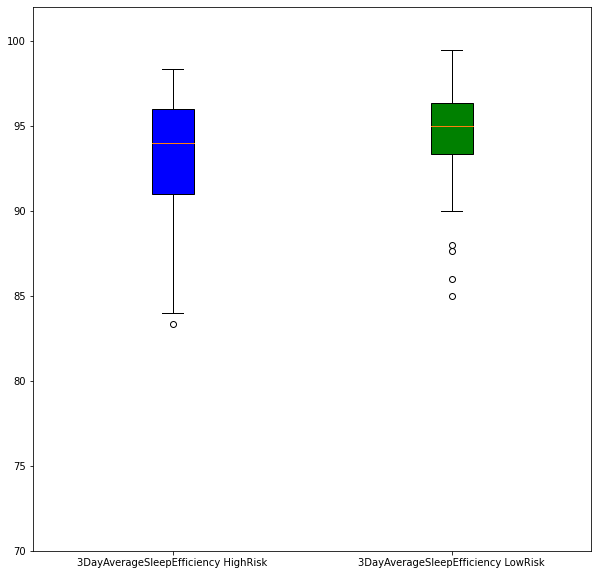

In [153]:
feat = ['3DayAverageSleepEfficiency']
fig = plt.figure(figsize= (10,10))
feat_dict = {}
for f in feat:
    feat_dict[f + ' ' + 'HighRisk'] = [x for x in list(highriskcopy.loc[:, f].values) if str(x) != 'nan']
    feat_dict[f + ' ' + 'LowRisk'] = [x for x in list(lowriskcopy.loc[:, f].values) if str(x) != 'nan']
box = plt.boxplot(x=feat_dict.values(), labels=feat_dict.keys(), patch_artist=True)

colors = ['blue', 'green', 'blue', 'green','blue', 'green', 'blue', 'green', 'blue', 'green']* 2

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylim([70, 102])
plt.show()

## Compute a Work Regularity feature

In [119]:
# Initialize work regularity frame
wri_table = pd.DataFrame()
participants = feature_table['User'].unique()

for p in list(participants):
    # Get total duration between first and last shift date
    shift_df = feature_table.loc[feature_table['User'] == p, ['Date','ShiftType']]
    shift_df.sort_values(by='Date', inplace=True)
    date_end = datetime.datetime.strptime(shift_df.Date.values[-1], '%Y-%m-%d')
    date_start = datetime.datetime.strptime(shift_df.Date.values[0], '%Y-%m-%d')
    length = (date_end - date_start).days + 1
    # We will calculate regularity for 30 minute intervals, 48 epochs per day
    row_len = 24*2
    
    exists = [False] * length
    idx2date = [None] * length
    
    # Will store a 1 for work and 0 for not working
    store = np.zeros([length, row_len])
    
    # Iterate through days
    for i in range(length):
        date = (date_start + datetime.timedelta(days=i)).strftime('%Y-%m-%d')
        idx2date[i] = date
        if date in list(shift_df['Date'].unique()):
            shift = shift_df.loc[shift_df['Date']==date, 'ShiftType'].values
            # Assign a 1 for the 30 minute intervals the individual is working based on the shift
            if shift[0] == 1.0:
                store[i,17:33] = np.ones([1,16])
                exists[i] = True
            elif shift[0] == 2.0:
                store[i,33:48] = np.ones([1,15])
                if i+1 < length:
                    store[i+1, 0] = 1
                    exists[i+1] = True
                exists[i] = True
            elif shift[0] == 3.0:
                store[i, 1:17] = np.ones([1,16])
                exists[i] = True
            elif shift[0] == 31.0:
                store[i, 1:33] = np.ones([1,32])
                exists[i] = True
            else:
                continue
        else:
            continue

    # SRI summation forumla
    corr = np.empty(length)
    corr[:] = np.NaN
    for i in range(length):
        cnt, tot = 0, 0
        for j in range(6):
            if i - j <= 0:
                continue
            if exists[i - j] and exists[i - j - 1]:
                cnt += 1
                tot += (store[i - j] != store[i - j - 1]).sum()
        if cnt > 0:
            corr[i] = ((tot / (cnt * 48))*200)-100
      
    # np.hstack will force corr values into string, assign data type to object beforehand to perform numeric operations
    corr_array = np.array(corr,dtype=object).reshape(-1,1)
    wri_curr = pd.DataFrame(np.hstack((np.array(idx2date).reshape(-1,1), corr_array)), columns = ['Date', 'WRI'])
    wri_curr['User'] = p

    try:
        wri_table = pd.concat((wri_table, wri_curr))
    except:
        wri_table = wri_curr

In [121]:
# Add WRI to feature table
feature_table = feature_table.merge(wri_table, how='outer', on=['Date', 'User'])

In [122]:
wri_table.WRI.unique()

array([nan, 33.333333333333314, -33.33333333333334, -100.0,
       -56.94444444444444, -34.375, -12.5, 31.25, 31.94444444444443,
       32.291666666666686, 32.5, -31.25, -52.77777777777778,
       -48.958333333333336, -64.58333333333333, -32.29166666666666,
       -11.111111111111114, 12.5, -54.16666666666667, -50.0,
       -77.77777777777777, -66.66666666666667, -76.38888888888889,
       -17.708333333333343, -37.5, -95.83333333333333, -97.91666666666667,
       -68.75, -2.083333333333343, -1.0416666666666572, -20.0,
       -32.638888888888886, -5.833333333333329, 0.0, -55.55555555555556,
       -51.04166666666667, -34.722222222222214, 29.166666666666686,
       -31.944444444444443, -47.916666666666664, -65.625,
       -45.833333333333336, 2.0833333333333286, 20.0, 16.66666666666667,
       11.111111111111114, 35.416666666666686, 37.5, -72.5,
       -60.833333333333336, 9.722222222222229, -9.722222222222214, 15.625,
       1.0416666666666714, -15.625, 6.666666666666671,
       -10.416

In [123]:
hrcopy2 = highrisk.copy()
lrcopy2 = lowrisk.copy()

hrcopy2 = hrcopy2.merge(wri_table, how='inner', on=['Date', 'User'])
lrcopy2 = lrcopy2.merge(wri_table, how='inner', on=['Date', 'User'])

In [124]:
# Create New Correlations table
wricorr = pd.DataFrame([[0,0,0]], columns = ['HighRisk Mean', 'LowRisk Mean', 'ANOVA P-Value'])

# ANOVA test, and correlation tests
hr = [x for x in list(hrcopy2.loc[:, 'WRI'].values) if str(x) != 'nan']
lr = [x for x in list(lrcopy2.loc[:, 'WRI'].values) if str(x) != 'nan']
pval = f_oneway(hr,lr)[1]
pval = round(pval, 4)
wricorr.loc['WRI',:] = [mean(hr), mean(lr), pval]

# Correct p values
corrected = multipletests(pvals=list(wricorr['ANOVA P-Value'].values),method='fdr_bh')
wricorr['Corrected P-Value'] = corrected[1]

# Drop row of zeros
wricorr.drop([0], inplace=True)

In [125]:
wricorr

,HighRisk Mean,LowRisk Mean,ANOVA P-Value,Corrected P-Value
WRI,-13.187057,-13.776794,0.8933,0.8933


## Overview of final participants with JBS data

In [127]:
users = list(jbs.User.unique())
print(users, len(users))

['1153', '1102', '1103', '1151', '1108', '1158', '1155', '1115', '1154', '1150', '1157', '1156', '1160', '1161', '1164', '1165', '1167', '1168', '1171', '1173'] 20


In [128]:
# Shift type has very little non null data 
# caffeine, alcoholic drinks, wake method, time to fall asleep, hours worked, overtime, and nosleep don't have a ton of data
feature_table.loc[feature_table['User'].isin(users)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 513 entries, 0 to 577
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   User                   513 non-null    object 
 1   Date                   513 non-null    object 
 2   CupsofCaffeine         368 non-null    float64
 3   AlcoholicDrinks        368 non-null    float64
 4   WakeMethod(0-2)        368 non-null    float64
 5   TimeToFallAsleep(0-5)  368 non-null    float64
 6   HoursWorked            368 non-null    float64
 7   OverTime(Mins)         368 non-null    float64
 8   NoSleep                368 non-null    float64
 9   ShiftType              205 non-null    float64
 10  AlertnessMorning       353 non-null    float64
 11  AlertnessEvening       351 non-null    float64
 12  HappinessMorning       353 non-null    float64
 13  HappinessEvening       351 non-null    float64
 14  EnergyMorning          353 non-null    float64
 15  Energy

In [129]:
feature_table.loc[feature_table['User'].isin(users), 'User'].value_counts()

1157    35
1156    35
1150    35
1158    35
1108    35
1160    35
1103    35
1161    35
1154    35
1153    34
1102    34
1151    34
1115    34
1155    34
1164    21
1165     7
Name: User, dtype: int64

## Create Final Feature Table

In [132]:
# add aggregate variables
highrisk = highrisk.merge(aggregates, how='inner', on=['User', 'Date'])
lowrisk = lowrisk.merge(aggregates, how='inner', on=['User', 'Date'])

In [133]:
# Add WRI
highrisk = highrisk.merge(wri_table, how='inner', on=['Date', 'User'])
lowrisk = lowrisk.merge(wri_table, how='inner', on=['Date', 'User'])

In [134]:
# Drop JBS scores and add column for risk
highrisk.drop(['EScore', 'DScore', 'PAScore'], axis=1, inplace=True)
highrisk.loc[:,'Burnout'] = np.ones(highrisk.shape[0])
lowrisk.drop(['EScore', 'DScore', 'PAScore'], axis=1, inplace=True)
lowrisk.loc[:,'Burnout'] = np.zeros(lowrisk.shape[0])

In [135]:
# Combine low/highrisk
final_ft = pd.concat([highrisk, lowrisk], axis=0, ignore_index=True)

In [136]:
final_ft.tail(10)

,User,Date,CupsofCaffeine,AlcoholicDrinks,WakeMethod(0-2),TimeToFallAsleep(0-5),HoursWorked,OverTime(Mins),NoSleep,ShiftType,...,5DaySTDRelaxMorning,7DaySTDRelaxMorning,3DayAverageRelaxEvening,5DayAverageRelaxEvening,7DayAverageRelaxEvening,3DaySTDRelaxEvening,5DaySTDRelaxEvening,7DaySTDRelaxEvening,WRI,Burnout
484,1115,2020-12-30,0.0,0.0,0.0,0.0,8.0,0.0,1.0,2.0,...,2.727636,25.385196,78.000000,76.8,77.857143,3.741657,3.762978,5.792324,33.333333,0.0
485,1115,2020-12-29,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,...,28.917815,25.269163,78.333333,79.2,76.142857,3.681787,6.177378,7.356796,-11.111111,0.0
486,1115,2020-12-28,0.0,0.0,0.0,2.0,0.0,0.0,1.0,NaN,...,29.411562,32.666528,77.666667,78.8,76.285714,4.496913,6.554388,7.323432,0.0,0.0
487,1115,2021-01-02,0.0,0.0,1.0,0.0,8.0,0.0,1.0,1.0,...,3.124100,3.642157,68.666667,71.4,74.000000,3.299832,4.317407,5.656854,-55.555556,0.0
488,1115,2020-12-26,0.0,0.0,0.0,1.0,8.0,0.0,1.0,3.0,...,34.874633,33.387032,77.666667,74.6,75.000000,8.013877,7.914544,6.718843,-11.111111,0.0
489,1115,2020-12-25,0.0,0.0,0.0,0.0,8.0,0.0,1.0,1.0,...,37.295576,34.363008,75.333333,75.4,74.857143,10.077478,7.812810,6.791351,-32.638889,0.0
490,1115,2020-12-24,0.0,0.0,0.0,1.0,8.0,0.0,1.0,3.0,...,30.022658,34.363008,70.666667,72.8,73.857143,4.189935,4.166533,4.882288,-33.333333,0.0
491,1115,2020-12-23,0.0,0.0,1.0,2.0,8.0,0.0,1.0,3.0,...,30.757113,34.033597,72.000000,72.6,74.285714,4.966555,4.223742,4.831867,-20.0,0.0
492,1115,2020-12-27,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,...,29.202740,34.137776,79.666667,75.2,75.285714,7.039571,8.034924,6.797358,-5.833333,0.0
493,1115,2020-12-22,0.0,0.0,0.0,0.0,8.0,0.0,1.0,1.0,...,38.427074,37.946794,75.666667,76.0,75.285714,0.471405,3.521363,3.282607,-33.333333,0.0


In [137]:
final_ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Columns: 126 entries, User to Burnout
dtypes: float64(121), object(5)
memory usage: 486.4+ KB


In [139]:
final_ft.to_csv('burnout.csv')